# HMC-NUTS with CmdStanPY for inference on synthetic data

We compare two bayesian models in the context of PK analysis: a model that sets relatively wide priors on PK parameter (model B), and one that uses informative priors on these parameteters (model A).

## Python imports and settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['ps.papersize'] = 'a4'
plt.rcParams['savefig.orientation'] = 'portrait'
%matplotlib inline
import seaborn as sns
import os
import pandas as pd
import json
import time #to delay exectutions

import cmdstanpy
import arviz as az
az.style.use('arviz-white')
!jupyter nbextension enable --py widgetsnbextension

np.set_printoptions(suppress=True)

import utils.ComputeInfoC as CIC
from utils.ComputePSIS import psisloo
from varname.helpers import Wrapper
from scipy.special import ndtri

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
#Setting the path for cmdstan
from cmdstanpy import cmdstan_path, set_cmdstan_path

set_cmdstan_path('/home/xyz/Torsten/cmdstan/')
cmdstanpath = cmdstan_path()

cwd = os.getcwd()

## Plot functions

In [3]:
def evaluate_fit(fit_vars, datapath, true_prms) :
    
    with open(datapath + '.json', 'r') as f:
        datajson = json.load(f)
        
    out = dict()
    
    CL_err = np.abs(fit_vars['CL_pop'] - true_prms['CL_pop'])
    V1_err = np.abs(fit_vars['V1_pop'] - true_prms['V1_pop'])
    ka_err = np.abs(fit_vars['ka_pop'] - true_prms['ka_pop'])
    
    mse = np.sum((fit['cHat'][np.subtract(datajson['iObs'], 1)] - datajson['cObs'])**2) / len(fit['cHat'])
    mse_pop_prms = np.sum([CL_err**2, V1_err**2, ka_err**2]) / 3
    
    out['CL_absErr'] = CL_err
    out['V1_absErr'] = V1_err
    out['ka_absErr'] = ka_err
    out['msecHat'] = mse
    out['msePopPrms'] = mse_pop_prms
    out['CL'] = fit_vars['CL_pop']
    out['V1'] = fit_vars['V1_pop']
    out['ka'] = fit_vars['ka_pop']
    out['sigma'] = fit_vars['sigma']
    
    return out 


def plot_ppc_az_new(data_path, pop_draws, ind_draws, nsub=None, figsize=(10, 10), obs_style='o', 
                   cHat_draws=None) :

    with open(data_path, 'r') as f:
        datajson = json.load(f)

    if nsub is None :
        nsub = datajson['nSub'] 

    fig, ax = plt.subplots(nrows=np.ceil(nsub/3).astype('int'), ncols=3, figsize=figsize)
        
    t = datajson['TIME']
    cObs = datajson['cObs']
    tObs = datajson['tObs']
    countObs = 0
    
    for i in range(nsub) :

        start_i =  datajson['starts'][i]-1
        end_i = datajson['ends'][i] 
        c_pop = np.array(pop_draws)[:, start_i:end_i]
        c_ind = np.array(ind_draws)[:, start_i:end_i]

        c_pop_mean = np.nanmean(c_pop, axis=0)
        c_pop_qlow = np.nanquantile(c_pop, 0.025, axis=0)
        c_pop_qhigh = np.nanquantile(c_pop, 0.975, axis=0)

        c_ind_mean = np.nanmean(c_ind, axis=0)
        c_ind_qlow = np.nanquantile(c_ind, 0.025, axis=0)
        c_ind_qhigh = np.nanquantile(c_ind, 0.975, axis=0)
        
        t_i = t[start_i:end_i]
        ireset = np.add(np.where(np.diff(t_i) > (24*7))[0].astype('int'), 1) #+1 bc we are going to insert 
        ireset = np.insert(ireset, 0, 0)
        ireset = np.append(ireset, len(t_i)-1)
        
        start_obs_i = datajson['starts_tObs'][i]
        end_obs_i = datajson['ends_tObs'][i] + 1
        tObs_i = tObs[start_obs_i:end_obs_i]
    
        ax[i//3][i%3].plot(tObs_i, cObs[countObs:countObs+datajson['nObsSub'][i]], 
                           obs_style, color='black', label='obs', markersize=8)

        for j in range(len(ireset)-1) :
            popmean, = ax[i//3][i%3].plot(t_i[ireset[j]:ireset[j+1]], c_pop_mean[ireset[j]:ireset[j+1]], 'x:b') 
            popCI = ax[i//3][i%3].fill_between(t_i[ireset[j]:ireset[j+1]], 
                                                c_pop_qlow[ireset[j]:ireset[j+1]], 
                                                c_pop_qhigh[ireset[j]:ireset[j+1]],
                                                alpha=0.2, color='blue')
            indmean, = ax[i//3][i%3].plot(t_i[ireset[j]:ireset[j+1]], c_ind_mean[ireset[j]:ireset[j+1]], 'x:r')
            indCI = ax[i//3][i%3].fill_between(t_i[ireset[j]:ireset[j+1]], 
                                                c_ind_qlow[ireset[j]:ireset[j+1]], 
                                                c_ind_qhigh[ireset[j]:ireset[j+1]], 
                                                alpha=0.2, color='red')
            if j == 0 :
                popmean.set_label('pop. mean')
                popCI.set_label('pop. CI 95%')
                indmean.set_label('ind. mean')
                indCI.set_label('ind CI 95%')
                
            if cHat_draws is not None :
                cHat, = ax[i//3][i%3].plot(t_i[ireset[j]:ireset[j+1]], 
                                           cHat_draws.mean(axis=0)[ireset[j]:ireset[j+1]], 
                                           'xg')
                if j == 0 :
                    cHat.set_label('ode estim. conc.')
                    
            
        ax[i//3][i%3].set(xlabel='time (h)', ylabel='conc.')
        ax[i//3][i%3].legend()
        countObs += 1
        
    
    return fig, ax



def plot_prior_posterior(prior_list, posterior_list, nchains=None, names=None) :

    if nchains is None :
        nchains = posterior_list[0].shape[0]
    chain_colors = sns.color_palette("hot")
            
    fig, ax = plt.subplots(ncols=max(len(prior_list),2), figsize=(16, 4))
    
    for i in range(len(prior_list)) :
        line1 = sns.kdeplot(prior_list[i], ax=ax[i], color='blue', fill=True, alpha=.3, label='prior')
        for ichain in range(nchains) :
            sns.kdeplot(posterior_list[i][ichain, :], ax=ax[i], color=chain_colors[ichain],
                        fill=True, alpha=.2, label='posterior chain ' + str(ichain+1))
        if names is not None :
            ax[i].set_xlabel(str(names[i]))
            ax[i].legend()
            
        if not ax[i].get_subplotspec().is_first_col() :
            ax[i].set(ylabel=None)
        else :
            ax[i].set_ylabel(ax[i].get_ylabel(), labelpad=20)
    return fig, ax


def compute_res(chains) :
    iObs = chains.observed_data['iObs'] - 1 #from stan to python 
    augmented_cObs = np.array(chains.observed_data['cObs'])
    augmented_cObs = augmented_cObs.reshape(1, 1, len(chains.observed_data['cObs']))
    residuals = chains.posterior['cHat'][:, :, iObs] - augmented_cObs
    return residuals

def rmse(residuals) :
    return float(np.sqrt(np.mean(residuals**2)))

def plot_residuals_time(chains, residuals, title='') :
    
    nchains = residuals.shape[0]
    ndraws = residuals.shape[1]
    chain_colors = sns.color_palette("hot")
    
    fig, ax = plt.subplots(figsize=(8, 4))
    for ichain in range(nchains) :
        for isample in range(ndraws) :
            plot, = ax.plot(chains.observed_data['tObs'], 
                            residuals[ichain, isample, :], 
                            'o', color=chain_colors[ichain], alpha=.25)
        plot.set_label('chain '+str(ichain+1))
    ax.plot(chains.observed_data['tObs'], np.mean(residuals, axis=0).mean(axis=0), 'ok', 
             label='averaged residuals ('+str(nchains)+r' chains $\times$'+str(ndraws)+' draws)') 
    ax.legend(loc='lower right', prop={'size': 12})
    ax.set(xlabel='Time (h)', ylabel=r'$\hat C_{obs} - C_{Obs}$') 
    #fig.suptitle('Residuals [concentration in blood] w.r.t. time ' + title, size=15)
    
    return fig, ax


def plot_res_hist(residuals, figsize=plt.rcParams["figure.figsize"]) :
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(residuals.mean(axis=0).mean(axis=0), stat='percent') 
    ax.set(xlabel=r'$\hat C_{obs} - C_{obs}$')
    #fig.suptitle('Distributions of the non-normalized residuals', size=15)
    return fig, ax


def plot_res_wrt_obs(chains) :
    
    iObs = chains.observed_data['iObs'] - 1 #from stan indexing to python indexing
    cHatObs = chains.posterior['cHat'][:, :, iObs]
    cPred_indObs = chains.posterior_predictive['cPred_ind'][:, :, iObs]
    cPred_popObs = chains.posterior_predictive['cPred_pop'][:, :, iObs]
    x = np.linspace(0, 3, 100)
    
    nchains = len(chains.posterior.chain)
    ndraws = len(chains.posterior.draw)
    chain_colors = plt.get_cmap('Set2').colors
    
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, rasterized=True)
    for ichain in range(nchains) :
        for isample in range(ndraws) :
            plot0, = ax[0].plot(chains.observed_data['cObs'], cHatObs[ichain, isample, :], 
                            'o', color=chain_colors[ichain], alpha=.25)
            plot1, = ax[1].plot(chains.observed_data['cObs'], cPred_indObs[ichain, isample, :],
                               'o', color=chain_colors[ichain], alpha=.25)
            plot2, = ax[2].plot(chains.observed_data['cObs'], cPred_popObs[ichain, isample, :],
                                'o', color=chain_colors[ichain], alpha=.25)
        plot0.set_label('chain '+str(ichain+1))
        plot1.set_label('chain '+str(ichain+1))
        plot2.set_label('chain '+str(ichain+1))

    ax[0].set(ylabel=r'$\hat C$', 
           title='Estimated concentration \n w.r.t. observations')
    ax[1].set(xlabel=r'$C_{Obs}$', ylabel=r'$C_{PredInd}$', 
           title='Pred. ind. concentration \n w.r.t. observations')
    ax[2].set(ylabel=r'$C_{PredPop}$', 
           title='Pred. pop. concentration \n w.r.t. observations')
    for a in ax.flatten() :
        a.plot(x, x, '--r', label='y=x')
        a.legend()
    fig.suptitle('Predictions w.r.t. observations', size=20)
    
    return fig, ax



def npde(chains) :
    
    countObs = 0
    nObsSub = chains.observed_data['nObsSub']
    cHatObs = chains.posterior['cHatObs']
    cObs = chains.observed_data['cObs']
    starts_tObs = chains.observed_data['starts_tObs'].to_numpy()
    ends_tObs = chains.observed_data['ends_tObs'].to_numpy()

    F = [[]]*int(chains.observed_data['nSub'])
    NPDE = [[]]*int(chains.observed_data['nSub'])

    for i in range(len(F)) :
        hat = cHatObs[:, :, countObs:countObs+int(nObsSub[i])]
        obs = cObs[countObs:countObs+int(nObsSub[i])].to_numpy().reshape((1, 1, int(nObsSub[i])))
        below = np.array(hat <= obs)
        F[i] = np.sum(below, axis=(0,1)) / (below.shape[0] * below.shape[1])
        countObs += 1
        NPDE[i] = ndtri(F[i])
    return NPDE

def plot_npde_time(chains, npde_list) :
    
    starts_tObs = chains.observed_data['starts_tObs'].to_numpy()
    ends_tObs = chains.observed_data['ends_tObs'].to_numpy()
    
    fig, ax = plt.subplots(num=4)
    for i in range(len(npde_list)) :
        ax.plot(chains.observed_data['tObs'][starts_tObs[i]:ends_tObs[i]+1], npde_list[i], 'ob')
    ax.set(xlabel='time', ylabel=r'$NPDE_{it}$')
    fig.suptitle('Normalized prediction distribution errors (NPDE) w.r.t. time', size=15)
    
    return fig, ax

def plot_compare_omega(chains) :
    normal = np.random.normal(0, 0.1, size=10000)
    omega_priors = [normal[normal >= 0] for i in range(3)]
    omega_posts = [chains.posterior['omega'][:, :, i].to_numpy() for i in range(3)]
    fig, ax = plot_prior_posterior(omega_priors, omega_posts, 
                                   names=[r'$\omega_{CL}$', r'$\omega_{V}$', r'$\omega_{k_a}$'])
    return fig, ax


def add_true_values(axes, legend_loc='upper left', legend_size='10') :
    axes[0].plot([7]*2, axes[0].get_ylim(), '--k', label='ground truth')
    axes[1].plot([65]*2, axes[1].get_ylim(), '--k', label='ground truth')
    axes[2].plot([2.5]*2, axes[2].get_ylim(), '--k', label='ground truth')
    for a in axes.flatten():
        a.legend(loc=legend_loc)
        if not a.get_subplotspec().is_first_col() :
            a.get_legend().remove() 
        else :
            plt.setp(a.get_legend().get_texts(), fontsize=legend_size)

In [4]:
def WAIC_LogLik(log_lik) :

    WAIC_arr = np.empty((log_lik.shape[0]))
    for ichain in range(log_lik.shape[0]) :
        waic = CIC.waic(log_lik[ichain])['waic']
        WAIC_arr[ichain] = waic
    WAIC_arr = np.array(WAIC_arr)
    return WAIC_arr.mean()

def LOO_LogLik(log_lik) :
    loo_array = np.empty((log_lik.shape[0],))
    for ichain in range(log_lik.shape[0]) :
        loo_out = psisloo(log_lik[ichain, :, :].to_numpy())
        loo_array[ichain] = loo_out['loo']
    return loo_array.mean()

Run Stan model with cmdstanpy: you don't have to create a function for that but here we did to avoid repeating the same tasks

In [5]:
def run_model(model_name, data_file, model_dir='model/', data_dir='data/pop_data/', 
              fitfolder_prefix = "output_hmc_" + "simul_",
              inits={'CL_pop': 7, 'V1_pop' : 70, 'ka_pop' : 1.6}, 
              nchains=2, warm_iters=2000, sample_iters=1000, save_warmup=0) :
    
    model_path = model_dir+model_name+'.stan'
    model = cmdstanpy.CmdStanModel(model_name, stan_file=model_path)
    
    data_path = data_dir + data_file 
    fit_foldername = fitfolder_prefix + model_name + '_' + data_file[:-5]
    output_dir = cwd + "/" + fit_foldername 
    !mkdir -p $output_dir
    print("out:", output_dir)
    
    hmc_fit = model.sample(data=data_path, inits=inits, chains=nchains, iter_warmup=warm_iters,
                          iter_sampling=sample_iters, save_warmup=save_warmup, output_dir=output_dir,
                          show_progress=True)
    
    ! $cmdstanpath/bin/diagnose $output_dir/*.csv
    
    ! $cmdstanpath/bin/stansummary $output_dir/*.csv | head -n 20
    
    return data_path, model_path, output_dir
    
    
def run_outputs(data_path, model_path, output_dir, interest_vars=['CL_pop', 'V1_pop', 'ka_pop', 'sigma']) :
    
    chains = az.from_cmdstan(posterior=output_dir + '/*.csv',
                             posterior_predictive=['cPred_pop', 'cPred_ind'],
                             observed_data=data_path)
    
    plt.figure(1)
    az.plot_trace(chains, var_names=interest_vars) 
    
    plt.figure(2)
    az.plot_pair(chains, var_names=interest_vars, figsize=(5, 5)) 

    plt.show()
    
    
    return chains

In [6]:
from scipy.stats import pearsonr
from itertools import product

def pearson_corr_omega(chains) :
    
    rho_corr = np.zeros((len(chains.posterior.chain), 3, 3))
    pval_corr = np.zeros((len(chains.posterior.chain), 3, 3))
    for ichain in range(len(chains.posterior.chain)) :
        for iomega, jomega in product(range(3), range(3)) :
            temp = pearsonr(chains.posterior['omega'][ichain, :, iomega].as_numpy(),
                            chains.posterior['omega'][ichain, :, jomega].as_numpy())
            rho_corr[ichain, iomega, jomega] = temp[0]
            pval_corr[ichain, iomega, jomega] = temp[1]
    return rho_corr, pval_corr

In [7]:
def font_size(ax, labelsize=20, ticksize=20) :
    try : 
        ax[0] 
        for a in ax.flatten() :
            for item in [a.title, a.xaxis.label, a.yaxis.label] :
                item.set_fontsize(labelsize)
            a.tick_params(axis='both', labelsize=ticksize)
    except :
        for item in [ax.title, ax.xaxis.label, ax.yaxis.label] :
            item.set_fontsize(labelsize)
        ax.tick_params(axis='both', labelsize=ticksize)

# Wide priors: model B

We first fit a model with relatively wide priors, we call model B. We encounter some issues in MCMC sampling, in addition to strong correlation in the posterior samples for two model parameters.

In [ ]:
data_path, model_path, output_dir = run_model('wide', 'torsten_sim_pop.json', nchains=4, sample_iters=2000) 

In [4]:
output_dir = 'output_hmc_simul_wide_torsten_sim_pop'
! $cmdstanpath/bin/stansummary $output_dir/*.csv

Inference for Stan model: wide_model
4 chains: each with iter=(2000,2000,2000,2000); warmup=(0,0,0,0); thin=(1,1,1,1); 8000 iterations saved.

Warmup took (1851, 1300, 1709, 1362) seconds, 1.7 hours total
Sampling took (1188, 1287, 2086, 1277) seconds, 1.6 hours total

                           Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__                    7.4e+02  1.7e+00  1.3e+01   7.2e+02   7.4e+02   7.6e+02  6.0e+01  1.0e-02  1.1e+00
accept_stat__              0.80  6.9e-02  2.2e-01      0.29      0.89      1.00  1.0e+01  1.8e-03  1.1e+00
stepsize__                0.033  6.8e-03  9.6e-03     0.018     0.039     0.044  2.0e+00  3.4e-04  3.4e+13
treedepth__                 7.2  7.0e-03  4.4e-01       7.0       7.0       8.0  4.0e+03  6.9e-01  6.1e+00
n_leapfrog__                159  8.8e-01  5.6e+01       127       127       255  4.0e+03  6.9e-01  1.6e+01
divergent__                0.00      nan  0.0e+00      0.00      0.00      0.00      na

X[92,2]                 5.1e+00  1.5e-01  5.8e+00   2.5e-01   3.2e+00   1.6e+01  1.5e+03  2.5e-01  1.0e+00
X[93,1]                 8.0e+00  9.9e-02  5.5e+00   1.6e+00   6.8e+00   1.8e+01  3.1e+03  5.3e-01  1.0e+00
X[93,2]                 7.6e+00  1.7e-01  5.9e+00   1.5e+00   6.2e+00   1.8e+01  1.2e+03  2.0e-01  1.0e+00
X[94,1]                 7.0e+00  9.4e-02  5.3e+00   1.1e+00   5.7e+00   1.7e+01  3.2e+03  5.4e-01  1.0e+00
X[94,2]                 7.0e+00  1.7e-01  5.8e+00   1.2e+00   5.6e+00   1.8e+01  1.2e+03  2.1e-01  1.0e+00
X[95,1]                 5.1e+00  8.1e-02  4.7e+00   4.7e-01   3.9e+00   1.4e+01  3.3e+03  5.6e-01  1.0e+00
X[95,2]                 5.7e+00  1.5e-01  5.4e+00   7.6e-01   4.3e+00   1.6e+01  1.3e+03  2.3e-01  1.0e+00
X[96,1]                 3.5e+01  4.1e-03  3.1e-01   3.5e+01   3.5e+01   3.5e+01  5.9e+03  1.0e+00  1.0e+00
X[96,2]                 1.1e-01  9.9e-03  5.8e-01   7.7e-06   9.3e-03   4.6e-01  3.5e+03  6.0e-01  1.0e+00
X[97,1]                 6.5e+01  7.6e

X[1573,1]               2.1e+01  3.2e-02  2.2e+00   2.0e+01   2.1e+01   2.5e+01  4.6e+03  7.9e-01  1.0e+00
X[1573,2]               4.2e+00  1.3e-01  5.8e+00   3.8e-02   1.9e+00   1.6e+01  1.9e+03  3.2e-01  1.0e+00
X[1574,1]               1.9e+01  4.5e-02  2.9e+00   1.5e+01   1.8e+01   2.4e+01  4.1e+03  7.1e-01  1.0e+00
X[1574,2]               6.3e+00  1.4e-01  5.5e+00   2.0e+00   4.2e+00   1.8e+01  1.6e+03  2.8e-01  1.0e+00
X[1575,1]               3.0e+01  3.3e-03  2.4e-01   3.0e+01   3.0e+01   3.0e+01  5.4e+03  9.3e-01  1.0e+00
X[1575,2]               3.7e-01  1.7e-02  1.0e+00   2.0e-05   3.4e-02   1.9e+00  3.6e+03  6.1e-01  1.0e+00
X[1576,1]               6.0e+01  6.7e-03  4.9e-01   6.0e+01   6.0e+01   6.1e+01  5.4e+03  9.3e-01  1.0e+00
X[1576,2]               7.4e-01  3.4e-02  2.0e+00   3.9e-05   6.8e-02   3.8e+00  3.6e+03  6.1e-01  1.0e+00
X[1577,1]               8.0e+01  8.9e-03  6.5e-01   8.0e+01   8.0e+01   8.1e+01  5.4e+03  9.3e-01  1.0e+00
X[1577,2]               9.8e-01  4.5e

XPred[178,2]            1.8e+01  4.3e-01  1.3e+01   5.6e+00   1.4e+01   4.3e+01  9.2e+02  1.6e-01  1.0e+00
XPred[179,1]            5.0e+00  6.5e-04  5.2e-02   5.0e+00   5.0e+00   5.1e+00  6.5e+03  1.1e+00  1.0e+00
XPred[179,2]            8.5e-02  3.8e-03  2.8e-01   2.5e-06   5.8e-03   3.9e-01  5.5e+03  9.4e-01  1.0e+00
XPred[180,1]            1.0e+01  1.3e-03  1.0e-01   1.0e+01   1.0e+01   1.0e+01  6.5e+03  1.1e+00  1.0e+00
XPred[180,2]            1.7e-01  7.5e-03  5.6e-01   4.9e-06   1.2e-02   7.8e-01  5.5e+03  9.4e-01  1.0e+00
XPred[181,1]            1.5e+01  2.0e-03  1.6e-01   1.5e+01   1.5e+01   1.5e+01  6.5e+03  1.1e+00  1.0e+00
XPred[181,2]            2.5e-01  1.1e-02  8.3e-01   7.4e-06   1.7e-02   1.2e+00  5.5e+03  9.4e-01  1.0e+00
XPred[182,1]            1.0e+01  1.3e-03  1.0e-01   1.0e+01   1.0e+01   1.0e+01  6.5e+03  1.1e+00  1.0e+00
XPred[182,2]            1.7e-01  7.5e-03  5.6e-01   4.9e-06   1.2e-02   7.8e-01  5.5e+03  9.4e-01  1.0e+00
XPred[183,1]            2.0e+01  2.6e

cHatPred[951]           3.1e-03  9.1e-05  7.8e-03   3.2e-07   4.0e-04   1.6e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[952]           6.2e-03  1.8e-04  1.6e-02   6.4e-07   8.0e-04   3.2e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[953]           9.3e-03  2.7e-04  2.3e-02   9.6e-07   1.2e-03   4.8e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[954]           3.1e-03  9.1e-05  7.8e-03   3.2e-07   4.0e-04   1.6e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[955]           6.2e-03  1.8e-04  1.6e-02   6.4e-07   8.0e-04   3.2e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[956]           9.3e-03  2.7e-04  2.3e-02   9.6e-07   1.2e-03   4.8e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[957]           3.1e-03  9.1e-05  7.8e-03   3.2e-07   4.0e-04   1.6e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[958]           6.2e-03  1.8e-04  1.6e-02   6.4e-07   8.0e-04   3.2e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[959]           9.3e-03  2.7e-04  2.3e-02   9.6e-07   1.2e-03   4.8e-02  7.3e+03  1.2e+00  1.0e+00
cHatPred[960]           1.2e-02  3.7e

cPred_ind[1688]         2.1e-02  6.2e-04  4.0e-02   0.0e+00   4.4e-03   9.9e-02  4.1e+03  7.0e-01  1.0e+00
cPred_ind[1689]         2.8e-02  8.1e-04  5.3e-02   0.0e+00   6.0e-03   1.3e-01  4.3e+03  7.4e-01  1.0e+00
cPred_ind[1690]         2.2e-01  3.2e-03  2.3e-01   2.8e-03   1.3e-01   7.1e-01  5.2e+03  8.8e-01  1.0e+00
cPred_ind[1691]         3.3e-01  2.4e-03  1.9e-01   1.2e-01   2.7e-01   7.4e-01  6.7e+03  1.1e+00  1.0e+00
cPred_ind[1692]         5.2e-01  2.4e-03  2.0e-01   2.3e-01   4.9e-01   9.0e-01  7.4e+03  1.3e+00  1.0e+00
cPred_ind[1693]         4.8e-01  2.4e-03  2.1e-01   1.8e-01   4.5e-01   8.7e-01  7.7e+03  1.3e+00  1.0e+00
cPred_ind[1694]         4.1e-01  2.4e-03  2.0e-01   1.2e-01   3.8e-01   7.9e-01  7.4e+03  1.3e+00  1.0e+00
cPred_ind[1695]         4.7e-03  1.4e-04  8.9e-03   0.0e+00   9.9e-04   2.2e-02  4.1e+03  7.0e-01  1.0e+00
cPred_ind[1696]         4.7e-03  1.4e-04  8.8e-03   0.0e+00   9.9e-04   2.2e-02  4.2e+03  7.1e-01  1.0e+00
cPred_ind[1697]         1.2e-02  3.5e

Comment: there is no covariates so THETA_ind = THETA_norm. 


Check the immediate Stan diagnostics that can indicate inadequate fitting:

In [18]:
output_dir = 'output_hmc_simul_wide_torsten_sim_pop'
! $cmdstanpath/bin/diagnose $output_dir/*.csv

Processing csv files: output_hmc_simul_wide_torsten_sim_pop/wide-20220725123045_1.csv, output_hmc_simul_wide_torsten_sim_pop/wide-20220725123045_2.csv, output_hmc_simul_wide_torsten_sim_pop/wide-20220725123045_3.csv, output_hmc_simul_wide_torsten_sim_pop/wide-20220725123045_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  etaStd[1,16], etaStd[2,16], etaStd[1,44], etaStd[2,44], etaStd[1,53], etaStd[2,53], etaStd[2,64], sigma, THETA_norm[16,1], THETA_norm[44,1], THETA_norm[53,1], THETA_norm[16,2], THETA_norm[64,2], THETA_norm[16,3], THETA_norm[44,3], THETA_norm[53,3], THETA_ind[16,1], THETA_ind[44,1], THETA_ind[53,1], THETA_ind[16,2], THETA_ind[64,2], THETA_ind[16,3], THETA_ind[44,3], THETA

<Figure size 720x480 with 0 Axes>

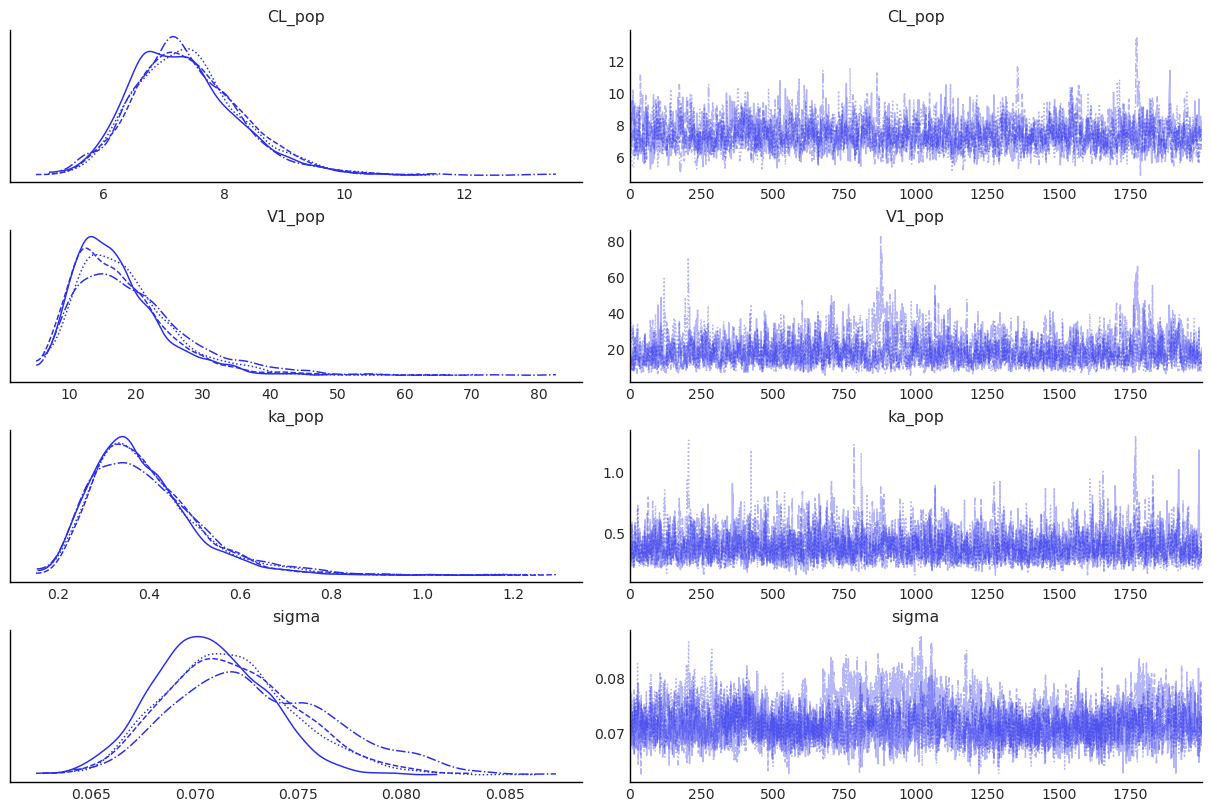

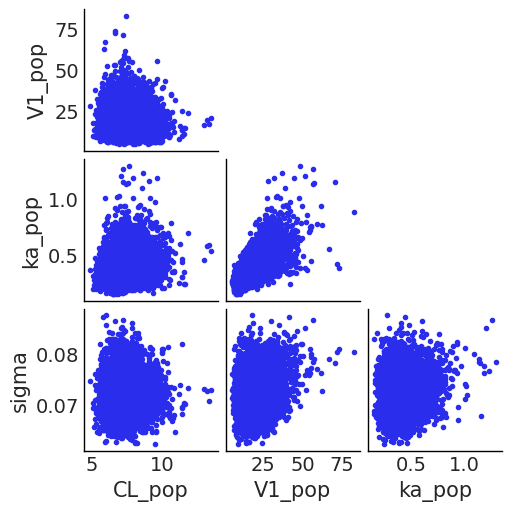

In [12]:
data_path = 'data/pop_data/torsten_sim_pop.json'
model_path = 'model/wide.stan'
output_dir = 'output_hmc_simul_wide_torsten_sim_pop'
chains = run_outputs(data_path, model_path, output_dir)

In [9]:
#i-th individual becomes i-1 in python indexing, while starts and ends indices are already in Stan's conventions. 
#but starts_tObs and ends_tObs were for python use, so they are not in Stan index conventions (+ 1)

print('16th individual')
print('start:', int(chains.observed_data['starts'][15]), 'end:',int(chains.observed_data['ends'][15]))
print('obs start:', int(chains.observed_data['starts_tObs'][15] + 1), 
      'obs end:',int(chains.observed_data['ends_tObs'][15] + 1))

print('44th individual')
print('start:', int(chains.observed_data['starts'][43]), 'end:',int(chains.observed_data['ends'][43]))
print('obs start:', int(chains.observed_data['starts_tObs'][43] + 1), 
      'obs end:',int(chains.observed_data['ends_tObs'][43] + 1))

print('53th individual')
print('start:', int(chains.observed_data['starts'][52]), 'end:',int(chains.observed_data['ends'][52]))
print('obs start:', int(chains.observed_data['starts_tObs'][52] + 1), 
      'obs end:',int(chains.observed_data['ends_tObs'][52] + 1))

print('64th individual')
print('start:', int(chains.observed_data['starts'][63]), 'end:',int(chains.observed_data['ends'][63]))
print('obs start:', int(chains.observed_data['starts_tObs'][63] + 1), 
      'obs end:',int(chains.observed_data['ends_tObs'][63] + 1))

#theres also some values of cHatObs for the 32th individual
print('32th individual')
print('start:', int(chains.observed_data['starts'][31]), 'end:',int(chains.observed_data['ends'][31]))
print('obs start:', int(chains.observed_data['starts_tObs'][31] + 1), 
      'obs end:',int(chains.observed_data['ends_tObs'][31] + 1))

16th individual
start: 383 end: 392
obs start: 69 obs end: 71
44th individual
start: 1168 end: 1180
obs start: 265 obs end: 267
53th individual
start: 1362 end: 1380
obs start: 319 obs end: 323
64th individual
start: 1650 end: 1674
obs start: 403 obs end: 410
32th individual
start: 806 end: 850
obs start: 172 obs end: 183


In [10]:
r_chain1 =  pearsonr(chains.posterior['V1_pop'][0, :].as_numpy(), chains.posterior['ka_pop'][0, :].as_numpy())
r_chain2 = pearsonr(chains.posterior['V1_pop'][1, :].as_numpy(), chains.posterior['ka_pop'][1, :].as_numpy())
r_chain3 = pearsonr(chains.posterior['V1_pop'][2, :].as_numpy(), chains.posterior['ka_pop'][2, :].as_numpy())
r_chain4 = pearsonr(chains.posterior['V1_pop'][3, :].as_numpy(), chains.posterior['ka_pop'][3, :].as_numpy())
print('chain 1: ', 'rho, uncorr_pvalue=', r_chain1)
print('chain 2: ', 'rho, uncorr_pvalue=', r_chain2)
print('chain 3: ', 'rho, uncorr_pvalue=', r_chain3)
print('chain 4: ', 'rho, uncorr_pvalue=', r_chain4)

chain 1:  rho, uncorr_pvalue= (0.7113961573508621, 2.281780756851417e-308)
chain 2:  rho, uncorr_pvalue= (0.7774571557811614, 0.0)
chain 3:  rho, uncorr_pvalue= (0.6960464110846032, 8.739406014235444e-290)
chain 4:  rho, uncorr_pvalue= (0.6880157578670212, 1.589991098003165e-280)


In [10]:
rVka = pearsonr(chains.posterior['V1_pop'].to_numpy().flatten(), chains.posterior['ka_pop'].to_numpy().flatten())
rVCL = pearsonr(chains.posterior['V1_pop'].to_numpy().flatten(), chains.posterior['CL_pop'].to_numpy().flatten())
rCLka = pearsonr(chains.posterior['CL_pop'].to_numpy().flatten(), chains.posterior['ka_pop'].to_numpy().flatten())

print('correlations', 'r(V, ka) = ', rVka[0], 'r(V, CL) = ', rVCL[0], 'r(CL, ka) = ', rCLka[0])

correlations r(V, ka) =  0.7129511927854959 r(V, CL) =  0.033881430808434934 r(CL, ka) =  0.19694482456757004


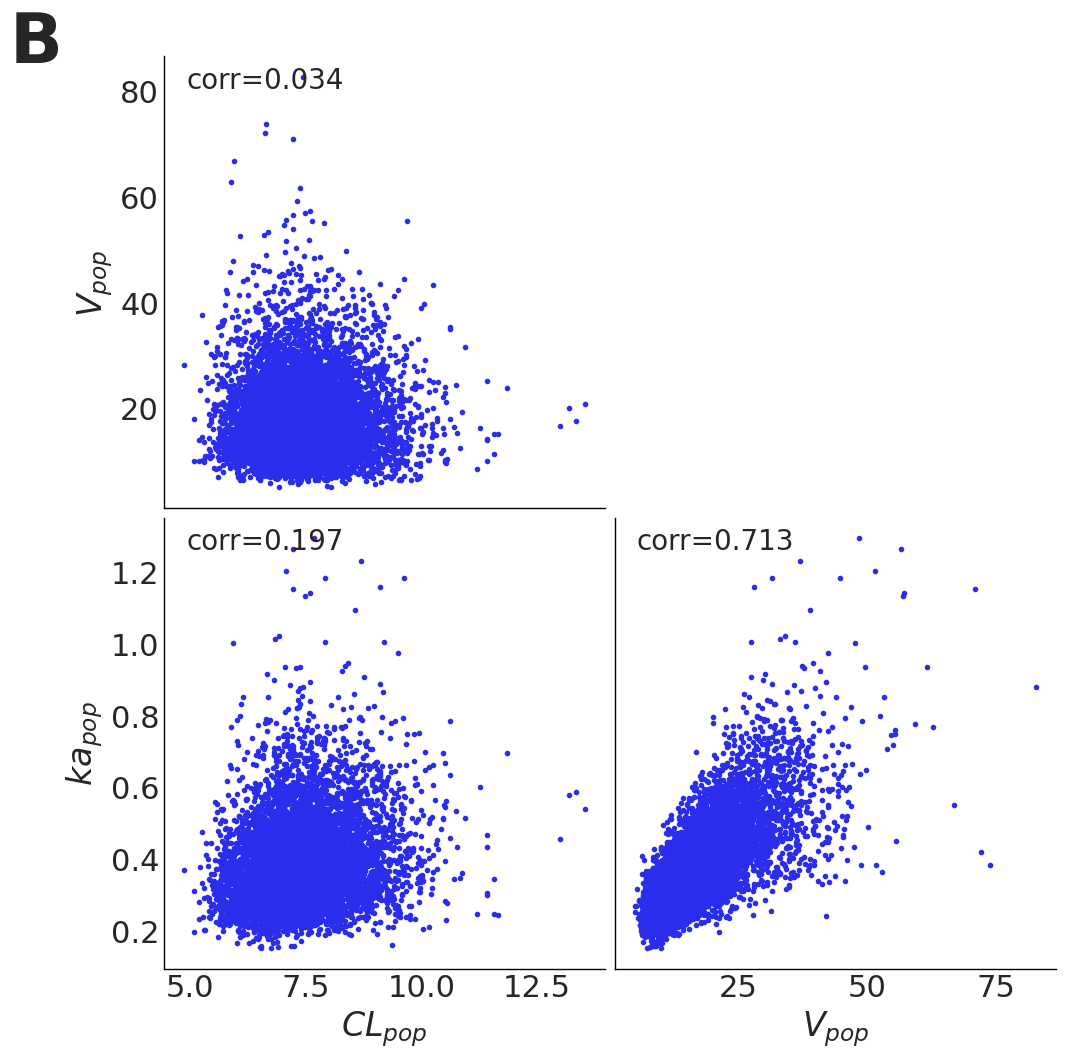

In [11]:
interest_vars=['CL_pop', 'V1_pop', 'ka_pop']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
with az.style.context("arviz-white", after_reset=True):
    az.plot_pair(chains, var_names=interest_vars, figsize=(10, 10), divergences=True, ax=ax) 
    ax[0, 0].set_ylabel(r'$V_{pop}$')
    ax[1, 0].set_ylabel(r'${ka}{_{pop}}$')
    ax[1, 0].set_xlabel(r'${CL}_{pop}$')
    ax[1, 1].set_xlabel(r'$V_{pop}$')
    ax[0, 0].annotate('corr='+str(np.round(rVCL[0], 3)), xy=(0.05, 0.93), xycoords='axes fraction', size=20)
    ax[1, 0].annotate('corr='+str(np.round(rCLka[0], 3)), xy=(0.05, 0.93), xycoords='axes fraction', size=20)
    ax[1, 1].annotate('corr='+str(np.round(rVka[0], 3)), xy=(0.05, 0.93), xycoords='axes fraction', size=20)
    
    font_size(ax, labelsize=24, ticksize=22)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.text(-0.05, 0.99, 'B', fontsize=50, transform=plt.gcf().transFigure, weight='bold')

plt.savefig('plots/modelB_pairs.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_pairs.eps', dpi=600, bbox_inches='tight')

In [301]:
import itertools
interest_vars=['CL_pop', 'V1_pop', 'ka_pop', 'sigma', 'omega']
r_list = []
for var_i, var_j in itertools.product(interest_vars, interest_vars):
    if var_i != var_j :
        if var_i == 'omega' and var_j != 'omega' :
            for i in range(3) :
                r_list.append(pearsonr(chains.posterior[var_i][:, :, i].to_numpy().flatten(), 
                                   chains.posterior[var_j].to_numpy().flatten())[0])
        elif var_j == 'omega' and var_i != 'omega' :
            continue
        else :
            r_list.append(pearsonr(chains.posterior[var_i].to_numpy().flatten(), 
                                   chains.posterior[var_j].to_numpy().flatten())[0])
        print(var_i, var_j, r_list[-1])

CL_pop V1_pop 0.033881430808434934
CL_pop ka_pop 0.19694482456757004
CL_pop sigma 0.02555431462872454
V1_pop CL_pop 0.033881430808434934
V1_pop ka_pop 0.7129511927854959
V1_pop sigma 0.2698802517063015
ka_pop CL_pop 0.19694482456757004
ka_pop V1_pop 0.7129511927854959
ka_pop sigma 0.1664039077021584
sigma CL_pop 0.02555431462872454
sigma V1_pop 0.2698802517063015
sigma ka_pop 0.1664039077021584
omega CL_pop 0.10314186591036438
omega V1_pop 0.030769621146209673
omega ka_pop 0.18542649762514157
omega sigma -0.25615055271942444


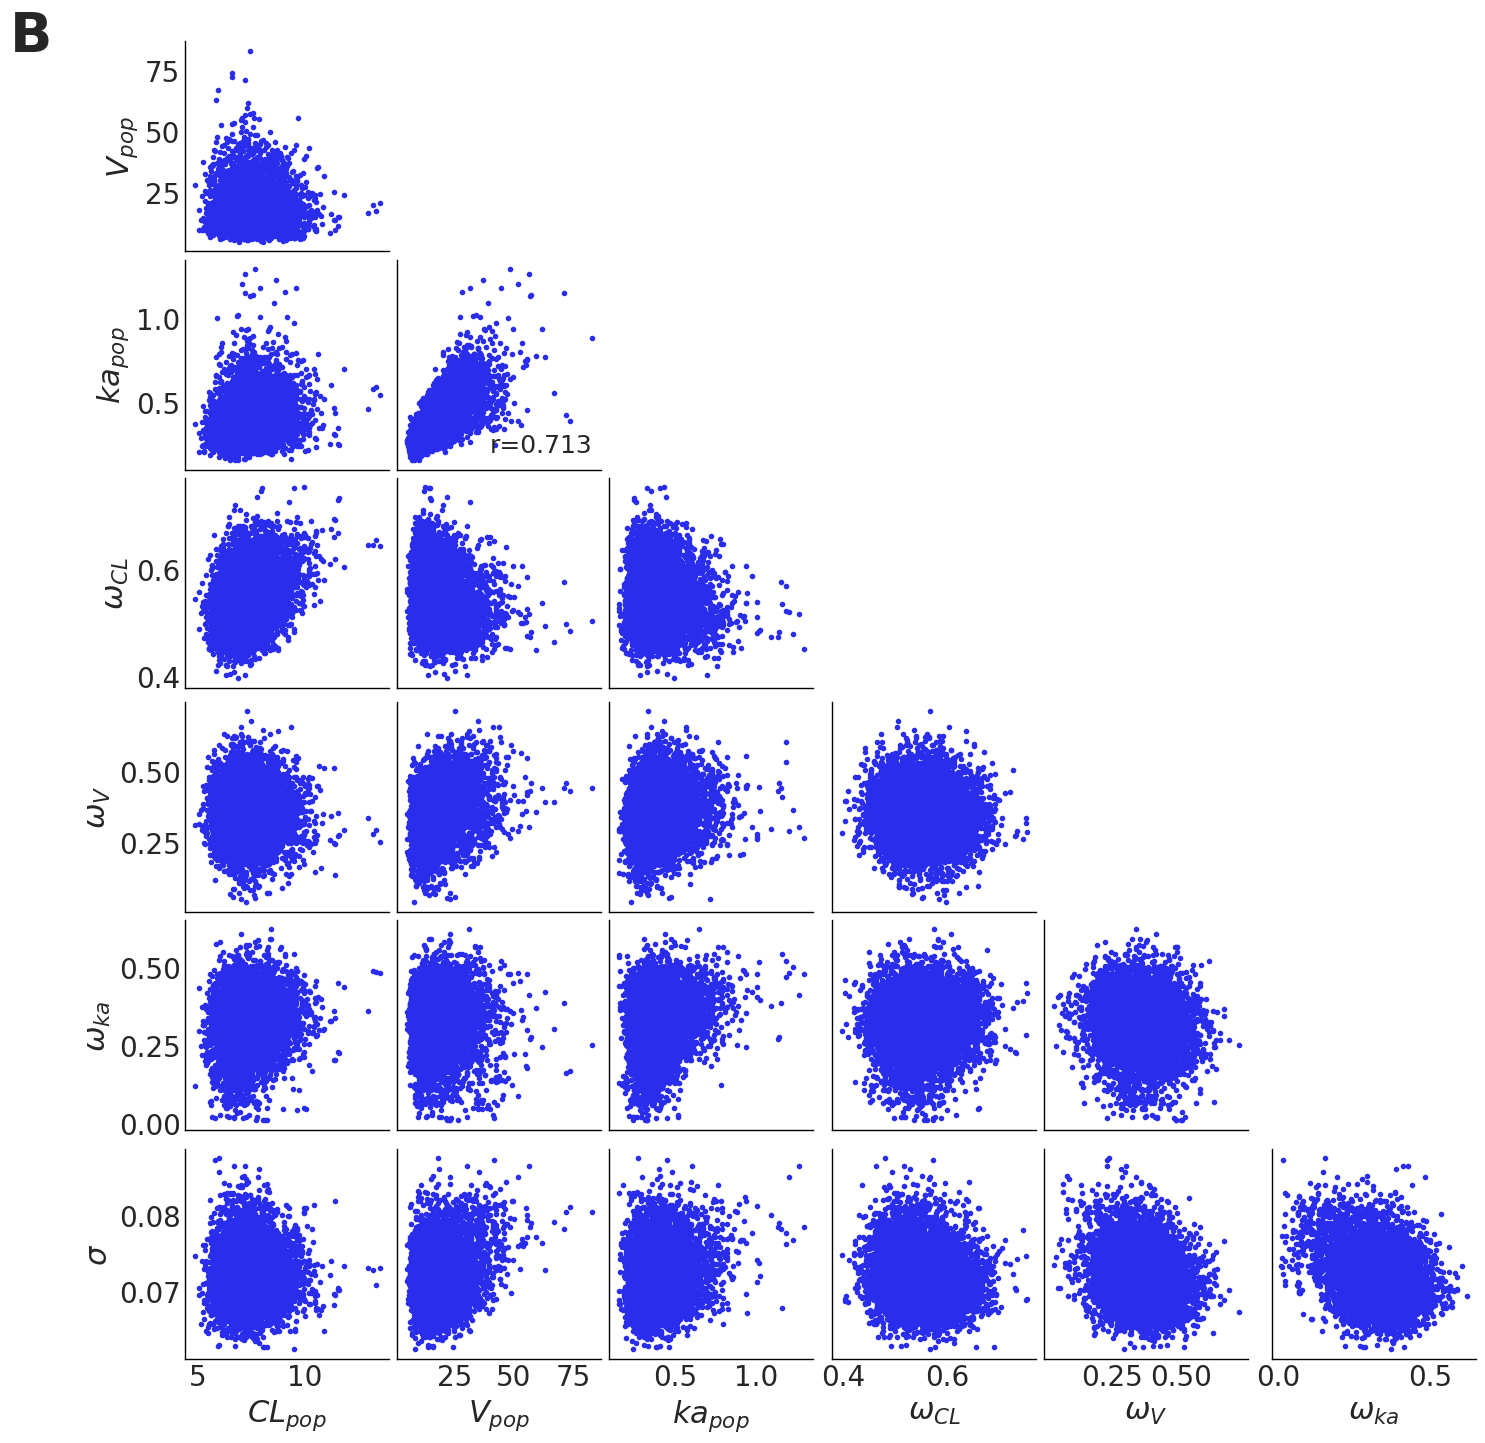

In [12]:
interest_vars=['CL_pop', 'V1_pop', 'ka_pop', 'omega', 'sigma']
var_names = [r'$CL_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$', r'$\omega_{CL}$', r'$\omega_V$', r'$\omega_{ka}$',
             r'$\sigma$']

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(14, 14))
with az.style.context("arviz-white", after_reset=True):
    az.plot_pair(chains, var_names=interest_vars, divergences=True, ax=ax) 
    for i in range(len(var_names)-1) :
        ax[-1, i].set_xlabel(var_names[i])
        ax[i , 0].set_ylabel(var_names[i+1])
    ax[1, 1].text(40, 0.2, 'r='+str(np.round(rVka[0], 3)),
                  size=18)
    font_size(ax, labelsize=22, ticksize=20)
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.text(-0.05, 0.99, 'B', fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelB_pairs_all.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_pairs_all.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/2900227954.py:23: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=2)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


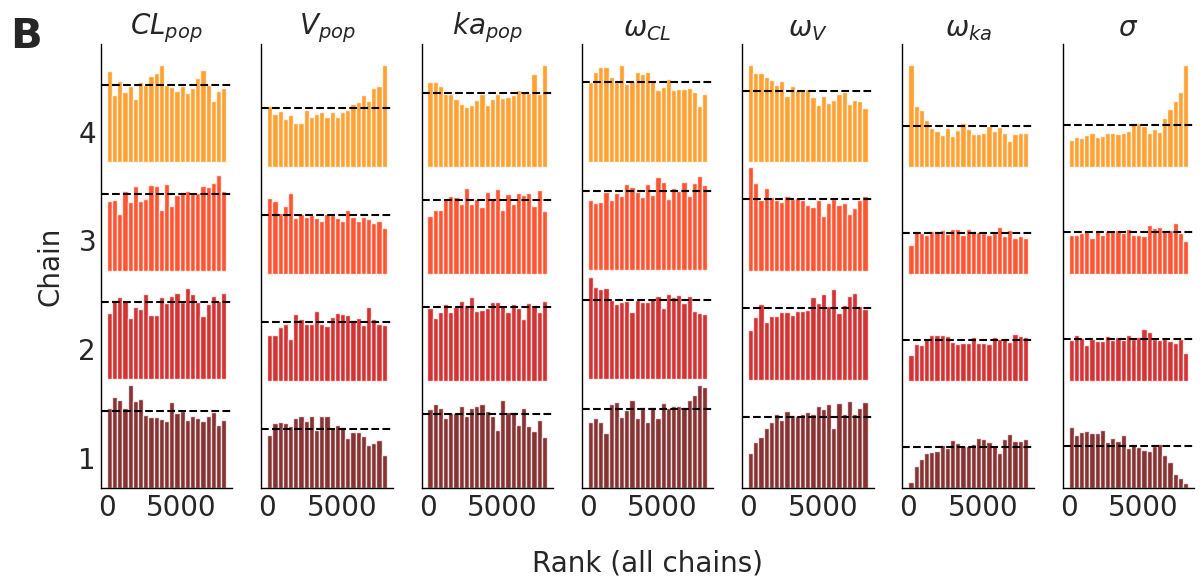

In [13]:
popvar_names = ['CL_pop', 'V1_pop', 'ka_pop', 'omega', 'sigma']
var_labels = [r'${CL}_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$', 
              r'$\omega_{CL}$', r'$\omega_{V}$', r'$\omega_{ka}$', r'$\sigma$']
ncols = len(var_labels)
fig, ax = plt.subplots(ncols=ncols, figsize=(12, 6), sharex=True)
az.plot_rank(chains, var_names=popvar_names, colors=sns.color_palette("hot"), 
             bar_kwargs={'alpha':0.8}, ax=ax)
for a in ax.flatten() :
    a.set(title=var_labels[a.get_subplotspec().num1 % ncols])

    if not a.get_subplotspec().num1 % ncols == ncols//2 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    if not a.get_subplotspec().num1 % ncols == 0 :
        a.set(ylabel=None)
        a.yaxis.set_ticklabels([])
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=10)
        a.set_yticks(a.get_yticks() + [0.00005])
        a.set_yticklabels(np.arange(1, 5, 1).astype('str'))

plt.tight_layout(pad=2)
plt.text(-0.01, 0.9, 'B', fontsize=30, transform=plt.gcf().transFigure, weight='bold')
font_size(ax)
plt.savefig('plots/modelB_rank.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_rank.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/648351067.py:38: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=1)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


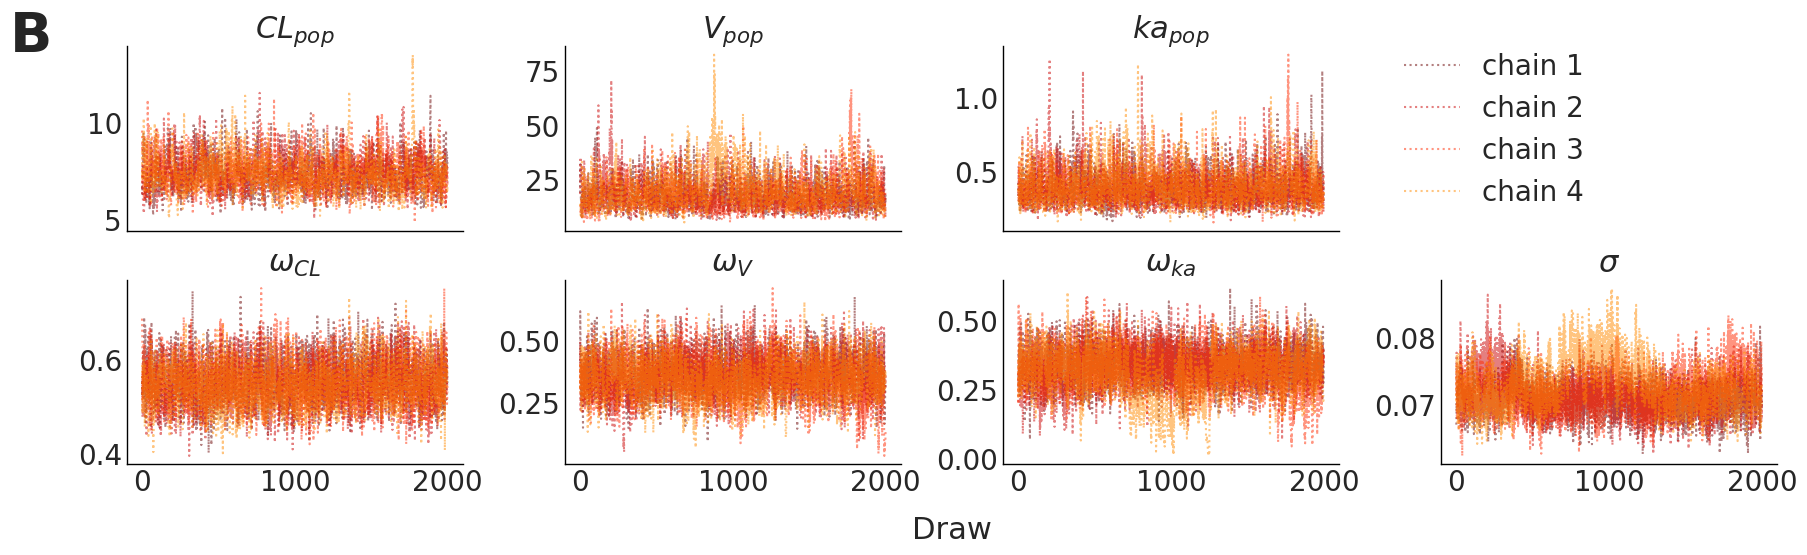

In [14]:
var_labels = [r'${CL}_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$', 
              r'$\omega_{CL}$', r'$\omega_{V}$', r'$\omega_{ka}$', r'$\sigma$']

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 6), sharex=True)
chain_colors = sns.color_palette("hot")
for ichain in range(4) :
    ax[0, 0].plot(chains.posterior['CL_pop'][ichain, :], color=chain_colors[ichain], 
                  linestyle=':', alpha=.5, 
                  label='chain '+ str(ichain+1))
    ax[0, 1].plot(chains.posterior['V1_pop'][ichain, :], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[0, 2].plot(chains.posterior['ka_pop'][ichain, :], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 3].plot(chains.posterior['sigma'][ichain, :], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 0].plot(chains.posterior['omega'][ichain, :, 0], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 1].plot(chains.posterior['omega'][ichain, :, 1], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 2].plot(chains.posterior['omega'][ichain, :, 2], color=chain_colors[ichain], linestyle=':', alpha=.5)
    
h, l = ax[0, 0].get_legend_handles_labels()

ia = 0
for a in ax.flatten() :
    
    if a.get_subplotspec().num1 != 3:
        a.set_title(var_labels[ia])
        ia += 1

    else :
        a.spines['left'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.xaxis.set_visible(False)
        a.yaxis.set_visible(False)
        a.legend(h, l, fontsize=20,  bbox_to_anchor=(0.5, 1.1))
        
font_size(ax, labelsize=22, ticksize=20)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Draw', labelpad=20, size=22)
plt.tight_layout(pad=1)
plt.text(-0.01, 0.9, 'B', fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelB_chains.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_chains.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/3609915350.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=2)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


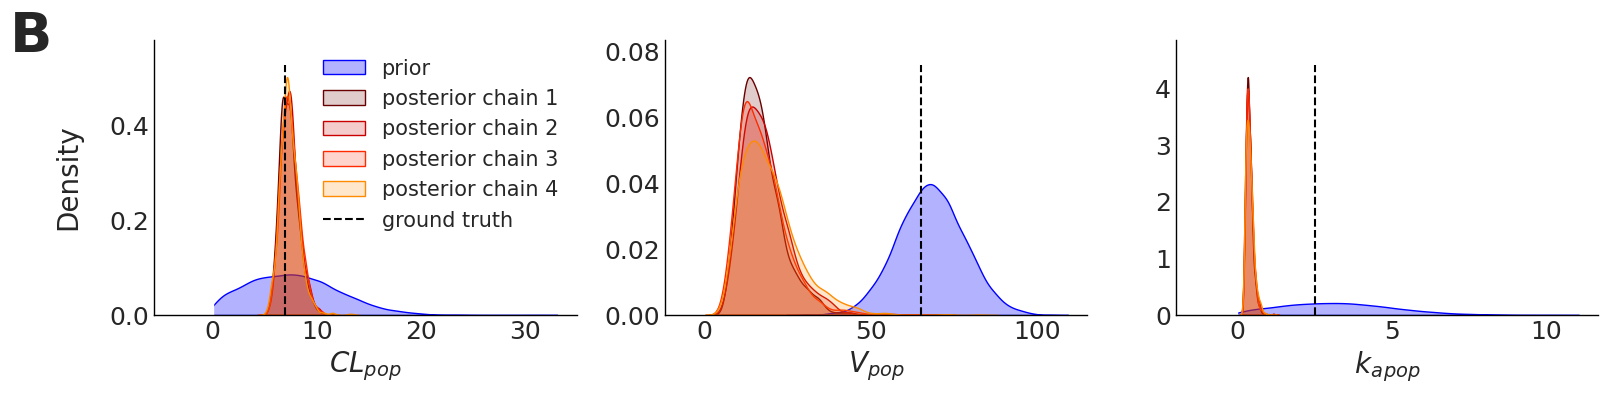

In [15]:
CL_prior = np.random.normal(7, 5, size=10000)
V_prior = np.random.normal(68, 10, size=10000)
ka_prior = np.random.normal(3, 2, size=10000)
PK_priors = [CL_prior[CL_prior >=0], V_prior[V_prior >=0], ka_prior[ka_prior >= 0]]
PK_posts = [chains.posterior['THETA_pop'][:, :, i].to_numpy() for i in range(3)]
fig3, ax = plot_prior_posterior(PK_priors, PK_posts, names=[r'$CL_{pop}$', r'$V_{pop}$', r'${k_a}_{pop}$'])
add_true_values(ax, legend_loc='upper right')

for a in ax.flatten() :
    if a.get_xlim()[0] < 0 :
        xblank = [a.get_xlim()[0]+0.07, 0]
        a.fill_between(xblank, 0, a.get_ylim()[1], color='white', step='post')
        
font_size(ax, labelsize=20, ticksize=18)
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h, l, fontsize=15)

fig.add_subplot(111, frameon=False)
plt.tight_layout(pad=2)
plt.text(-0.01, 0.9, 'B', fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelB_priorpost.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_priorpost.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/3450722561.py:53: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=.8)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


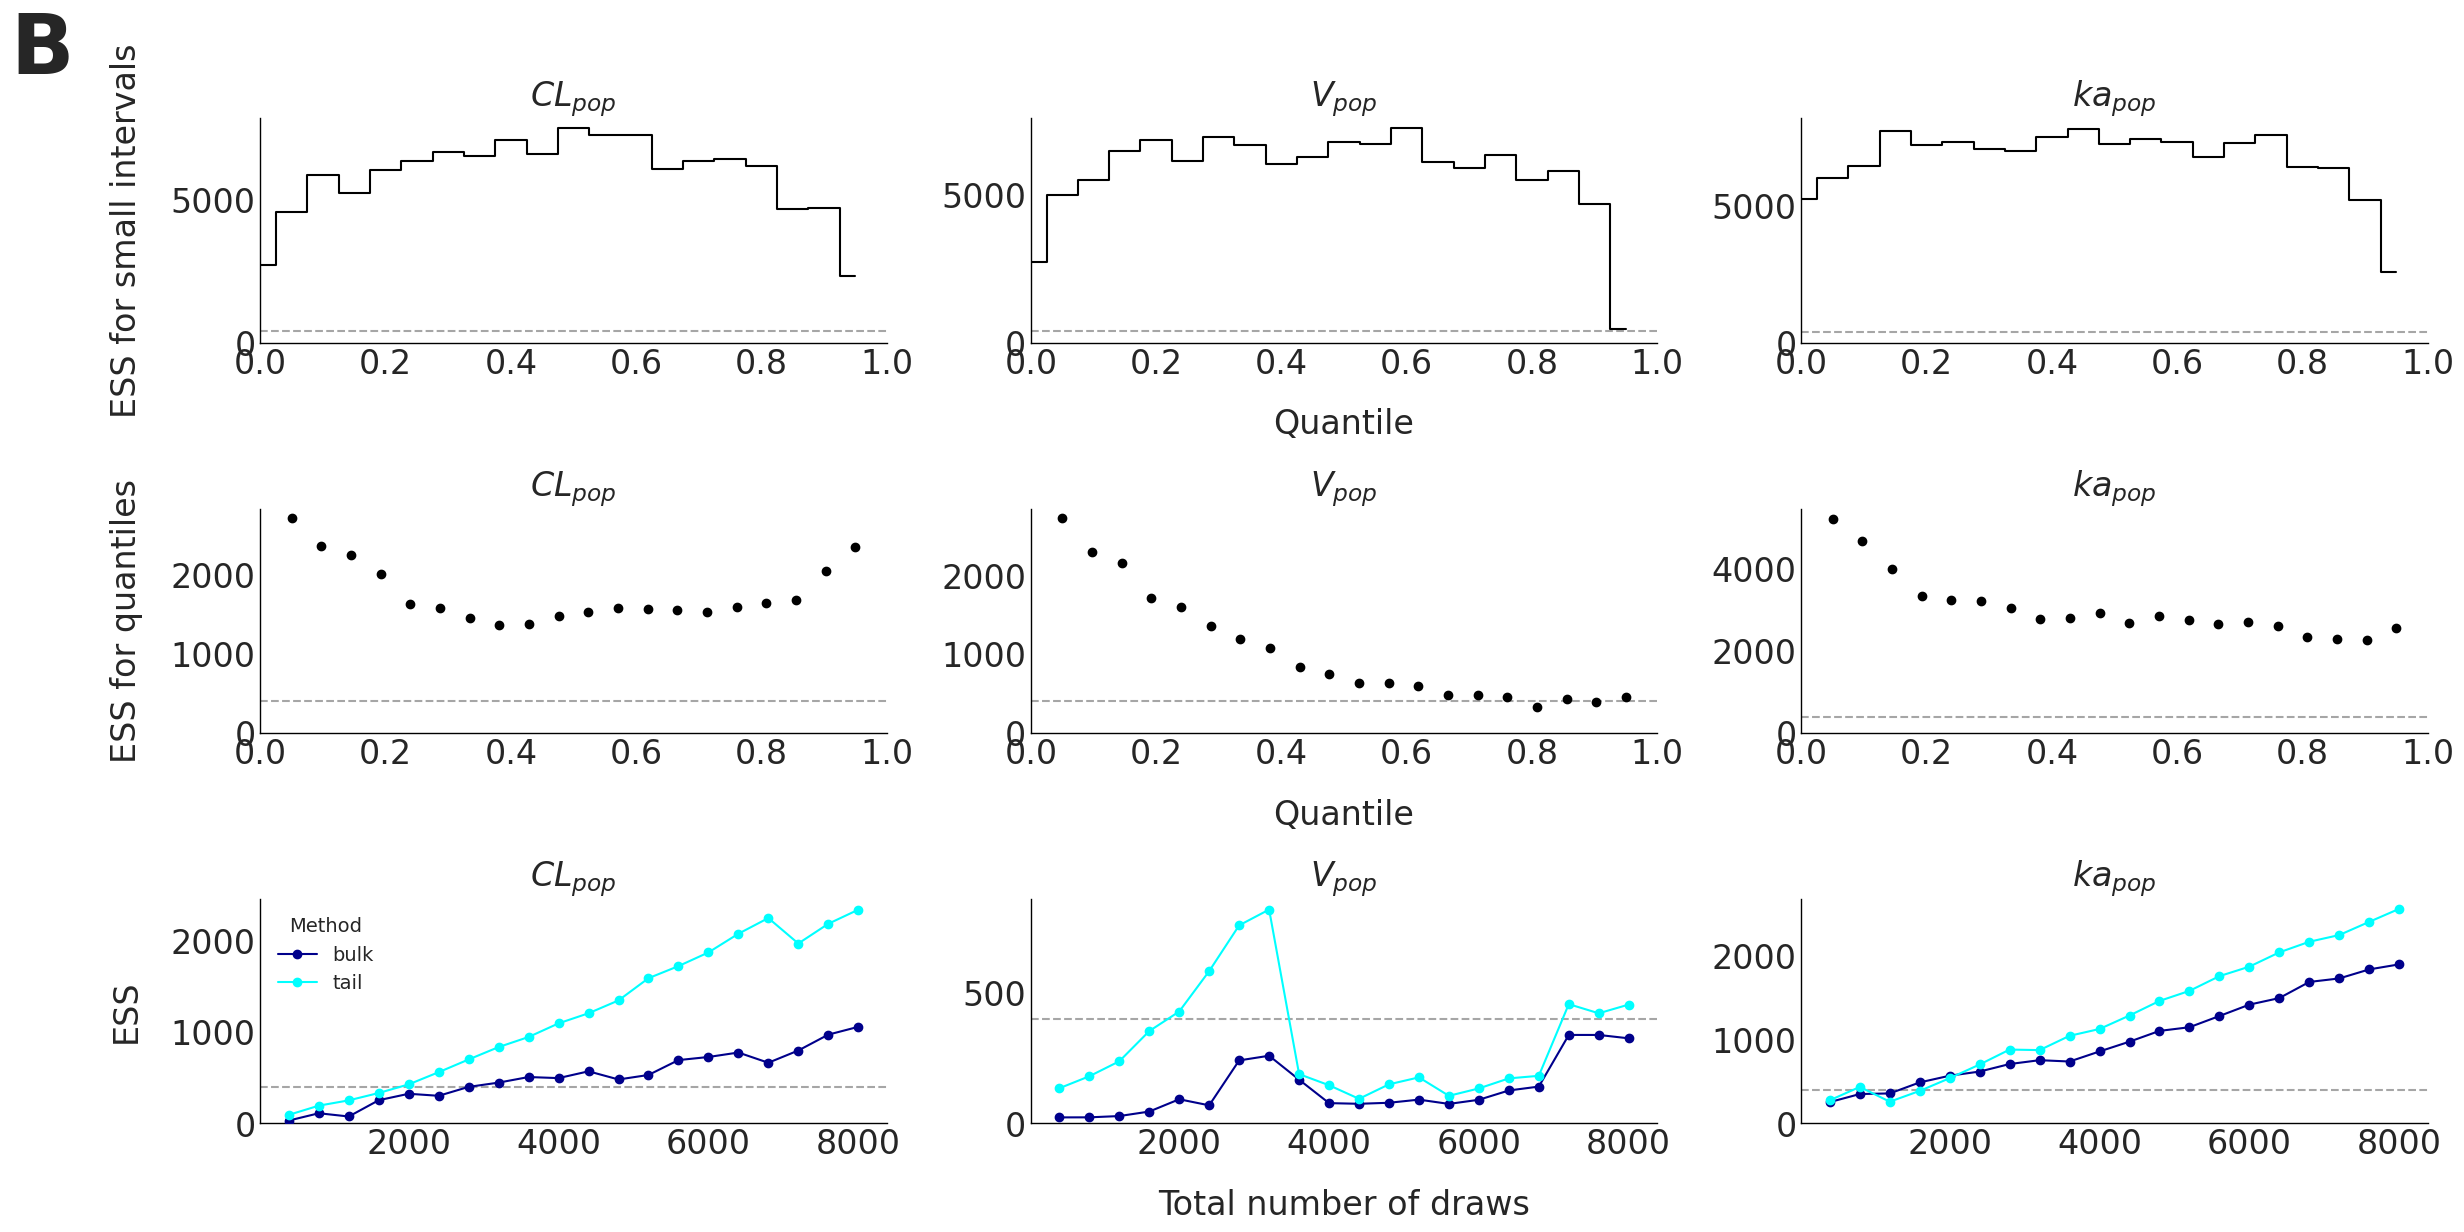

In [16]:
pop_var_names = ['CL_pop', 'V1_pop', 'ka_pop']
var_labels = [r'${CL}_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8*3, 4*3))


az.plot_ess(chains, var_names=pop_var_names, ax = ax[0, :], kind='local',
            drawstyle="steps-mid", linestyle='-', marker=None, color='black') 

for a in ax[0, :].flatten():
    if not a.get_subplotspec().is_first_col() :
        a.set(ylabel=None)
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=20)
    if not a.get_subplotspec().num1 % 3 == 1 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    a.set(title=var_labels[a.get_subplotspec().num1 % 3])

    
az.plot_ess(chains, var_names=pop_var_names, ax = ax[1, :], kind='quantile',
           color='black') 

for a in ax[1, :].flatten():
    if not a.get_subplotspec().is_first_col() :
        a.set(ylabel=None)
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=20)
    if not a.get_subplotspec().num1 % 3 == 1 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    a.set(title=var_labels[a.get_subplotspec().num1 % 3])
    
    
az.plot_ess(chains, var_names=pop_var_names, kind='evolution', ax=ax[2, :], 
            color='darkblue', extra_kwargs={'color':'cyan'}) 

for a in ax[2, :].flatten():
    if not a.get_subplotspec().is_first_col() :
        a.get_legend().remove() 
        a.set(ylabel=None)
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=20)
    if not a.get_subplotspec().num1 % 3 == 1 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    a.set(title=var_labels[a.get_subplotspec().num1 % 3])
    
font_size(ax, ticksize=24, labelsize=24)
fig.subplots_adjust(hspace=.8)

plt.tight_layout(pad=2)
plt.text(-0.03, 0.98, 'B',fontsize=60, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelB_ess.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_ess.eps', dpi=600, bbox_inches='tight')

In [17]:
ess_wide = az.ess(chains)
stepsize_wide = chains.sample_stats['step_size']
nstep_wide = chains.sample_stats['n_steps']

In [13]:
residuals_B = compute_res(chains)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


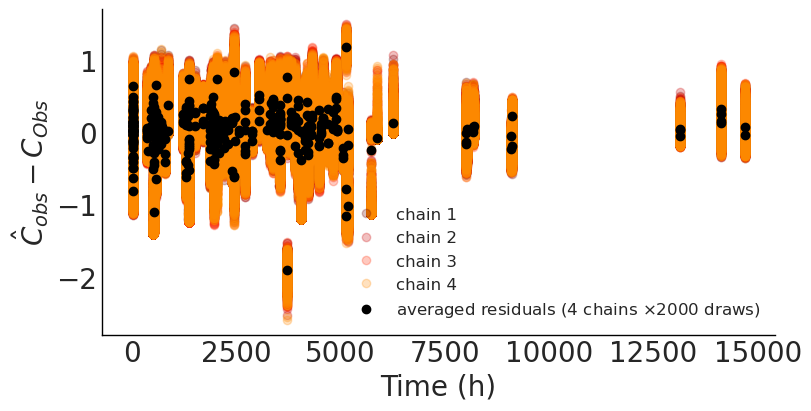

In [19]:
fig, ax = plot_residuals_time(chains, residuals_B) 
font_size(ax)
plt.savefig('plots/modelB_restime.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_restime.eps', dpi=600, bbox_inches='tight')

In [272]:
B_rmse = rmse(residuals_B)
B_rmse

0.33058623345111965

In [31]:
np.linalg.norm(residuals_B) / np.sqrt(len(np.array(residuals_B).flatten()))

0.33058623345111954

/tmp/ipykernel_5389/2927625616.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=2)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


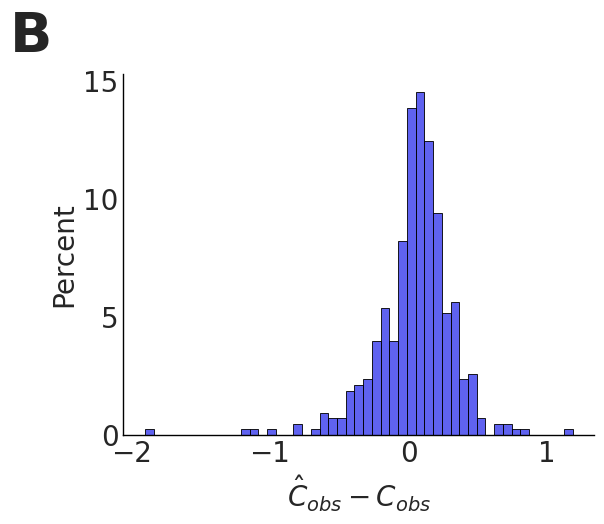

In [17]:
fig, ax = plot_res_hist(residuals_B, figsize=(6, 5))
font_size(ax)
plt.tight_layout(pad=2)
plt.text(-0.02, 0.98, 'B',fontsize=40, transform=plt.gcf().transFigure, weight='bold')
ax.set_xticks([-2, -1, 0, 1])
plt.savefig('plots/modelB_res.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_res.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/2540642969.py:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=1)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


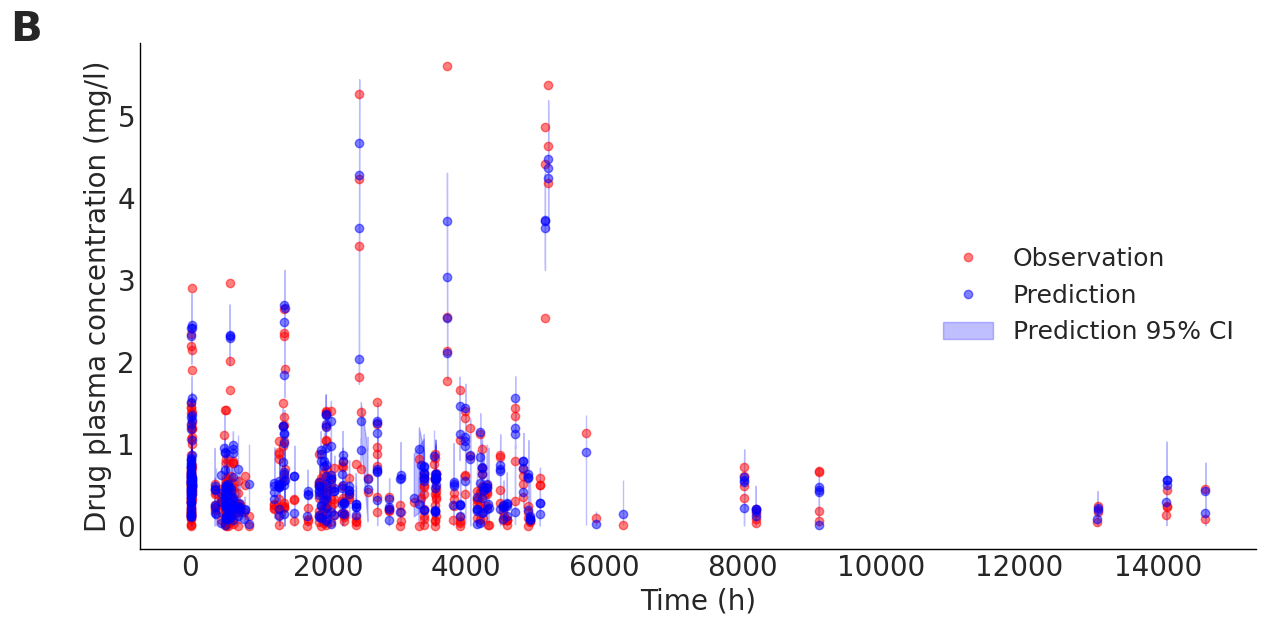

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
TIME = chains.observed_data['TIME']
tObs = chains.observed_data['tObs']

cPred = chains.posterior_predictive['cPred_ind'].to_numpy()
iObs = chains.observed_data['iObs'].to_numpy() - 1
cPredObs = cPred[:, :, iObs]

cPredmean = np.mean(cPredObs, axis=0).mean(axis=0)
qlower = np.quantile(cPredObs, 0.025, axis=[0,1])
qupper = np.quantile(cPredObs, 0.975, axis=[0,1])

t_reset = np.add(np.where(np.abs(np.diff(tObs)) > (24*7))[0].astype('int'), 1)
t_reset = np.insert(t_reset, 0, 0)
t_reset = np.append(t_reset, len(t_reset)-1)

ax.plot(tObs, chains.observed_data['cObs'], 'or', alpha=0.5, label='Observation')

for t in range(len(t_reset)-1) :
    ax.plot(tObs[t_reset[t]:t_reset[t+1]], cPredmean[t_reset[t]:t_reset[t+1]],
            'ob', alpha=0.5, label='Prediction') 
    ax.fill_between(tObs[t_reset[t]:t_reset[t+1]],
                    qlower[t_reset[t]:t_reset[t+1]],
                    qupper[t_reset[t]:t_reset[t+1]],
                    alpha=0.25, color='blue', label='Prediction 95% CI')
    if t==0 :
        ax.legend()
        
ax.set(xlabel='Time (h)', ylabel='Drug plasma concentration (mg/l)')
h, l = ax.get_legend_handles_labels()
ax.legend(h[:3], l[:3], fontsize=18, loc='center right')
font_size(ax)
plt.tight_layout(pad=1)
plt.text(-0.05, 0.98, 'B', fontsize=30, transform=plt.gcf().transFigure, weight='bold')

plt.savefig('plots/modelB_cPred.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelB_cPred.eps', dpi=600, bbox_inches='tight')

In [273]:
print(nstep_wide.mean(), nstep_wide.std(), 
     stepsize_wide.mean(), stepsize_wide.std(),
     )

<xarray.DataArray 'n_steps' ()>
array(158.784) <xarray.DataArray 'n_steps' ()>
array(55.67406348) <xarray.DataArray 'step_size' ()>
array(0.03345147) <xarray.DataArray 'step_size' ()>
array(0.00962073)


In [274]:
essB_dict = ess_wide.to_dict()
essB = pd.DataFrame(essB_dict)
essB_new = essB['CL_pop':'cHatPred'].drop(['THETA_pop', 'THETA_norm', 'THETAPred_norm']) #duplicates
essB_new = essB_new['data_vars'].apply(lambda x: list(x.values())[-1])

In [275]:
essB_new

CL_pop                                                 1057.963345
V1_pop                                                  326.366657
ka_pop                                                 1893.120541
L                [[8000.0, 8000.0, 8000.0], [1617.982286061079,...
omega            [1272.071005024688, 449.7278646941577, 141.837...
etaStd           [[6270.400251231685, 11756.104504802646, 8200....
sigma                                                    40.001749
THETA_ind        [[6063.0671349264385, 600.0117956004186, 3260....
X                [[3330.0523883343094, 1428.007916136871], [326...
cHat             [2422.0722153714823, 2422.074145423539, 2422.0...
cHatObs          [6170.85358853076, 5685.8651773837755, 5305.67...
logcHatObs       [6170.9223102267715, 5685.838581839455, 5305.7...
etaStdPred       [[7780.7547958976875, 8230.334368405653, 7853....
THETAPred_ind    [[6549.57633450402, 756.797911328069, 3693.391...
XPred            [[4101.625605456016, 2755.879249799427], [404

In [276]:
print(essB_new.apply(lambda x: np.mean(x)).mean(),
      essB_new.apply(lambda x: np.min(x)).min(),
      essB_new.apply(lambda x: np.max(x)).max())

3630.8012077233107 26.911924397398028 13138.54523105326


In [277]:
az.waic(chains, scale='deviance')

/home/xyz/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 by 427 log-likelihood matrix

              Estimate       SE
deviance_waic 113679.84  15134.47
p_waic        56303.03        -

There has been a warning during the calculation. Please check the results.

In [278]:
rhat = az.rhat(chains)

/home/xyz/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [279]:
rhat_01 = rhat > 1.01 

In [280]:
rhat_dict = rhat_01.sum().to_dict()
rhat_df = pd.DataFrame(rhat_dict)
rhat_new = rhat_df['CL_pop':'cHatPred'].drop(['THETA_pop', 'THETA_norm', 'THETAPred_norm']) #duplicates
rhat_new = rhat_new['data_vars'].apply(lambda x: list(x.values())[-1])

In [281]:
rhat_new[:'THETA_ind'].sum() / 418 #percent of parameters with rhat > 1.01

0.08851674641148326

# Informative priors: Model A

We fit a model that has more informative priors put on its PK parameters. This model results in better sampling properties, more accurate inference and uncorelated posterior samples. 

In [ ]:
data_path, model_path, output_dir = run_model('intermediate2', 'torsten_sim_pop.json', nchains=4, sample_iters=2000) 

Load the model, with arviz

<Figure size 720x480 with 0 Axes>

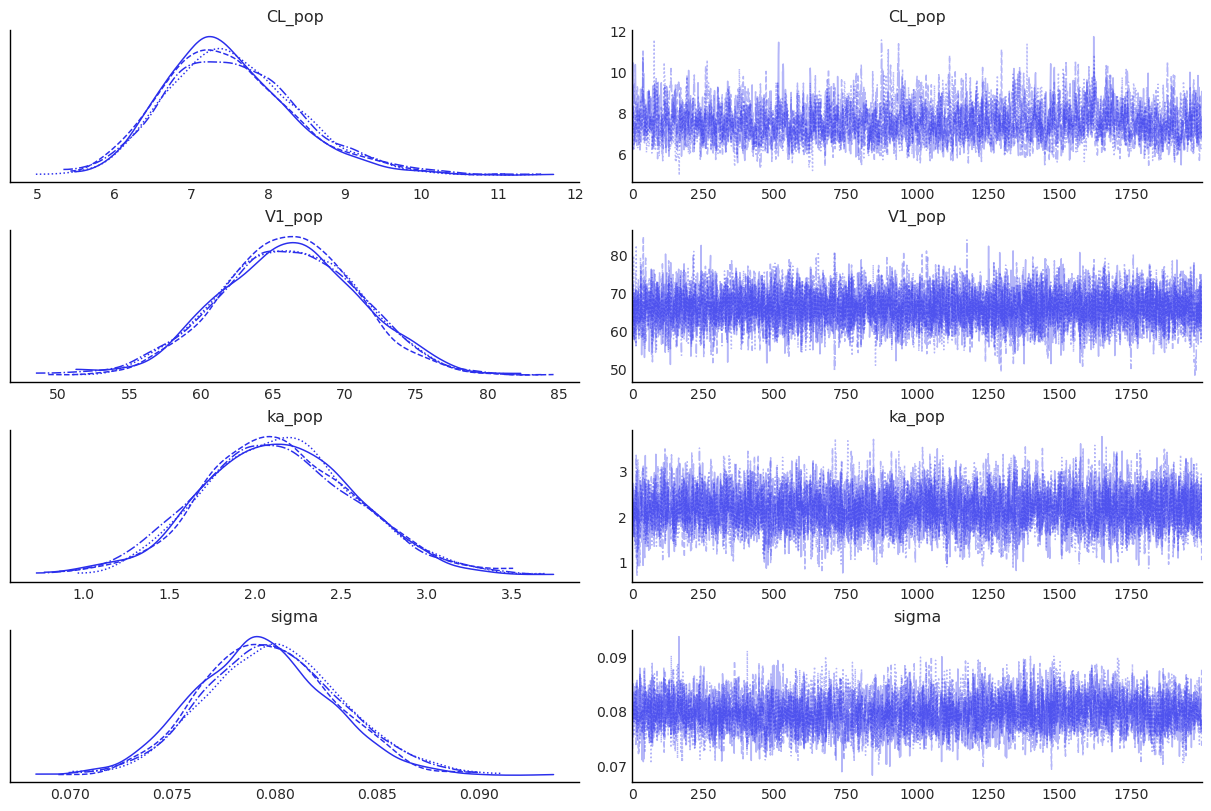

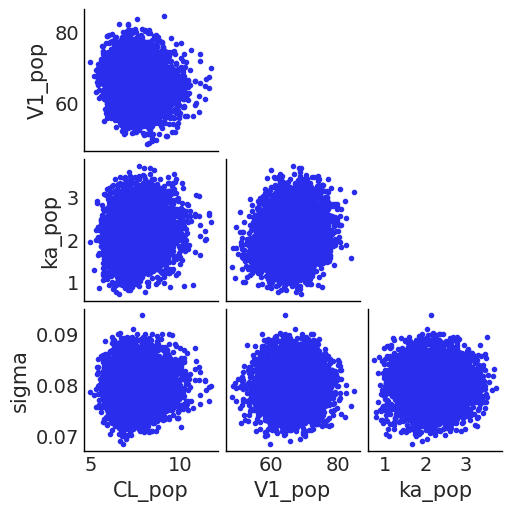

In [8]:
data_path = 'data/pop_data/torsten_sim_pop.json'
model_path = 'model/intermediate2.stan'
#outut_dir = 'output_hmc_simul_intermediate2_torsten_sim_pop'
output_dir = 'output_hmc_simul_A'
chains = run_outputs(data_path, model_path, output_dir)

In [9]:
output_dir = 'output_hmc_simul_A'
! $cmdstanpath/bin/stansummary $output_dir/*.csv

Inference for Stan model: intermediate2_model
4 chains: each with iter=(2000,2000,2000,2000); warmup=(0,0,0,0); thin=(1,1,1,1); 8000 iterations saved.

Warmup took (1253, 1225, 1652, 1906) seconds, 1.7 hours total
Sampling took (1124, 1140, 1642, 1524) seconds, 1.5 hours total

                           Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__                    7.1e+02  6.1e-01  1.2e+01   6.9e+02   7.1e+02   7.3e+02  3.6e+02  6.6e-02  1.0e+00
accept_stat__              0.78  8.2e-03  2.1e-01      0.35      0.85      0.99  6.4e+02  1.2e-01  1.0e+00
stepsize__                0.046  7.2e-05  1.0e-04     0.046     0.046     0.046  2.0e+00  3.7e-04  2.7e+11
treedepth__                 6.9  4.1e-03  3.5e-01       6.0       7.0       7.0  7.4e+03  1.4e+00  1.0e+00
n_leapfrog__                121  2.2e-01  1.9e+01        63       127       127  7.3e+03  1.3e+00  1.0e+00
divergent__                0.00      nan  0.0e+00      0.00      0.00      0.0

cHat[634]               3.1e-02  2.7e-04  2.2e-02   4.2e-03   2.7e-02   7.2e-02  6.7e+03  1.2e+00  1.0e+00
cHat[635]               6.2e-02  5.3e-04  4.4e-02   8.4e-03   5.3e-02   1.4e-01  6.7e+03  1.2e+00  1.0e+00
cHat[636]               8.6e-02  7.5e-04  6.1e-02   1.2e-02   7.4e-02   2.0e-01  6.7e+03  1.2e+00  1.0e+00
cHat[637]               1.1e-01  9.6e-04  7.9e-02   1.5e-02   9.6e-02   2.6e-01  6.7e+03  1.2e+00  1.0e+00
cHat[638]               3.1e-02  2.7e-04  2.2e-02   4.2e-03   2.7e-02   7.2e-02  6.7e+03  1.2e+00  1.0e+00
cHat[639]               6.2e-02  5.3e-04  4.4e-02   8.4e-03   5.3e-02   1.4e-01  6.7e+03  1.2e+00  1.0e+00
cHat[640]               8.6e-02  7.5e-04  6.1e-02   1.2e-02   7.4e-02   2.0e-01  6.7e+03  1.2e+00  1.0e+00
cHat[641]               1.1e-01  9.6e-04  7.9e-02   1.5e-02   9.6e-02   2.6e-01  6.7e+03  1.2e+00  1.0e+00
cHat[642]               4.8e-01  1.8e-03  1.6e-01   2.1e-01   4.8e-01   7.5e-01  7.6e+03  1.4e+00  1.0e+00
cHat[643]               4.8e-01  1.8e

XPred[838,1]            6.8e+00  6.3e-02  5.2e+00   4.6e-01   5.7e+00   1.7e+01  6.7e+03  1.2e+00  1.0e+00
XPred[838,2]            7.8e+01  5.2e-01  3.8e+01   3.6e+01   7.0e+01   1.5e+02  5.6e+03  1.0e+00  1.0e+00
XPred[839,1]            1.5e+00  2.6e-02  2.1e+00   3.2e-03   6.0e-01   5.9e+00  6.5e+03  1.2e+00  1.0e+00
XPred[839,2]            7.5e+01  5.3e-01  4.0e+01   3.1e+01   6.7e+01   1.5e+02  5.7e+03  1.0e+00  1.0e+00
XPred[840,1]            4.5e-01  1.2e-02  9.8e-01   3.3e-05   7.6e-02   2.2e+00  6.7e+03  1.2e+00  1.0e+00
XPred[840,2]            6.9e+01  5.3e-01  4.0e+01   2.4e+01   6.1e+01   1.4e+02  5.7e+03  1.1e+00  1.0e+00
XPred[841,1]            5.0e+01  1.3e-06  1.2e-04   5.0e+01   5.0e+01   5.0e+01  8.0e+03  1.5e+00  1.0e+00
XPred[841,2]            7.3e+00  1.4e-01  1.0e+01   8.1e-02   3.9e+00   2.6e+01  5.7e+03  1.1e+00  1.0e+00
XPred[842,1]            9.5e+01  2.4e-06  2.2e-04   9.5e+01   9.5e+01   9.5e+01  8.0e+03  1.5e+00  1.0e+00
XPred[842,2]            1.4e+01  2.6e

cPred_pop[1268]         3.0e-01  2.9e-03  2.3e-01   2.5e-02   2.5e-01   7.5e-01  6.4e+03  1.2e+00  1.0e+00
cPred_pop[1269]         2.9e-01  2.9e-03  2.3e-01   2.3e-02   2.4e-01   7.4e-01  6.5e+03  1.2e+00  1.0e+00
cPred_pop[1270]         5.1e-01  2.9e-03  2.3e-01   2.3e-01   4.6e-01   9.4e-01  6.3e+03  1.2e+00  1.0e+00
cPred_pop[1271]         4.9e-01  3.0e-03  2.4e-01   2.0e-01   4.4e-01   9.5e-01  6.6e+03  1.2e+00  1.0e+00
cPred_pop[1272]         0.0e+00      nan  0.0e+00   0.0e+00   0.0e+00   0.0e+00      nan      nan      nan
cPred_pop[1273]         4.9e-01  1.5e-03  1.3e-01   3.0e-01   4.9e-01   7.1e-01  7.4e+03  1.4e+00  1.0e+00
cPred_pop[1274]         6.3e-01  2.7e-03  2.3e-01   2.9e-01   6.2e-01   1.0e+00  7.1e+03  1.3e+00  1.0e+00
cPred_pop[1275]         7.6e-01  4.0e-03  3.3e-01   2.8e-01   7.3e-01   1.3e+00  6.9e+03  1.3e+00  1.0e+00
cPred_pop[1276]         6.5e-06  1.5e-06  1.3e-04   0.0e+00   0.0e+00   0.0e+00  7.1e+03  1.3e+00  1.0e+00
cPred_pop[1277]         2.5e-01  7.1e

In [11]:
output_dir = 'output_hmc_simul_A'
! $cmdstanpath/bin/diagnose $output_dir/*.csv

Processing csv files: output_hmc_simul_A/intermediate2-20220725162048_2.csv, output_hmc_simul_A/intermediate2-20220725162048_3.csv, output_hmc_simul_A/modelA-20221004180044_2.csv, output_hmc_simul_A/modelA-20221004180044_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  etaStd[1,53], X[1373,2], X[1374,2], X[1376,2], X[1380,2], cHat[1362], cHat[1363], cHat[1364], cHat[1365], cHat[1366], cHat[1367], cHat[1368], cHat[1369], cHat[1370], cHat[1371], cHat[1372], cHat[1373], cHat[1374], cHat[1375], cHat[1376], cHat[1377], cHat[1378], cHat[1379], cHat[1380], cHatObs[319], cHatObs[320], cHatObs[321], cHatObs[322], cHatObs[323], logcHatObs[319], logcHatObs[320], logcHatObs[321], logcHatObs[322], log

The 53th individual has R hat higher than 1.05 for his individual CL parameters. We investigate below and see from the index that all other $\hat R$ warnings come from the same individual. EXCEPTED etaStd.

In [13]:
print('53th individual')
print('start:', int(chains.observed_data['starts'][52]), 'end:',int(chains.observed_data['ends'][52]))
print('obs start:', int(chains.observed_data['starts_tObs'][52] + 1), 
      'obs end:',int(chains.observed_data['ends_tObs'][52] + 1))

53th individual
start: 1362 end: 1380
obs start: 319 obs end: 323


In [23]:
np.quantile(chains.posterior['CL_pop'], [0.025, 0.975])
np.quantile(chains.posterior['V1_pop'], [0.025, 0.975])
np.quantile(chains.posterior['ka_pop'], [0.025, 0.975])
np.quantile(chains.posterior['sigma'], [0.025, 0.975])
np.quantile(chains.posterior['omega'][:, :, 0], [0.025, 0.975])
np.quantile(chains.posterior['omega'][:, :, 1], [0.025, 0.975])
np.quantile(chains.posterior['omega'][:, :, 2], [0.025, 0.975])

array([0.2817309 , 0.54210642])

In [10]:
rVka = pearsonr(chains.posterior['V1_pop'].to_numpy().flatten(), chains.posterior['ka_pop'].to_numpy().flatten())
rVCL = pearsonr(chains.posterior['V1_pop'].to_numpy().flatten(), chains.posterior['CL_pop'].to_numpy().flatten())
rCLka = pearsonr(chains.posterior['CL_pop'].to_numpy().flatten(), chains.posterior['ka_pop'].to_numpy().flatten())

print('correlations', 'r(V, ka) = ', rVka[0], 'r(V, CL) = ', rVCL[0], 'r(CL, ka) = ', rCLka[0])

correlations r(V, ka) =  0.1744427619685879 r(V, CL) =  -0.08671149454421717 r(CL, ka) =  0.11325947027519118


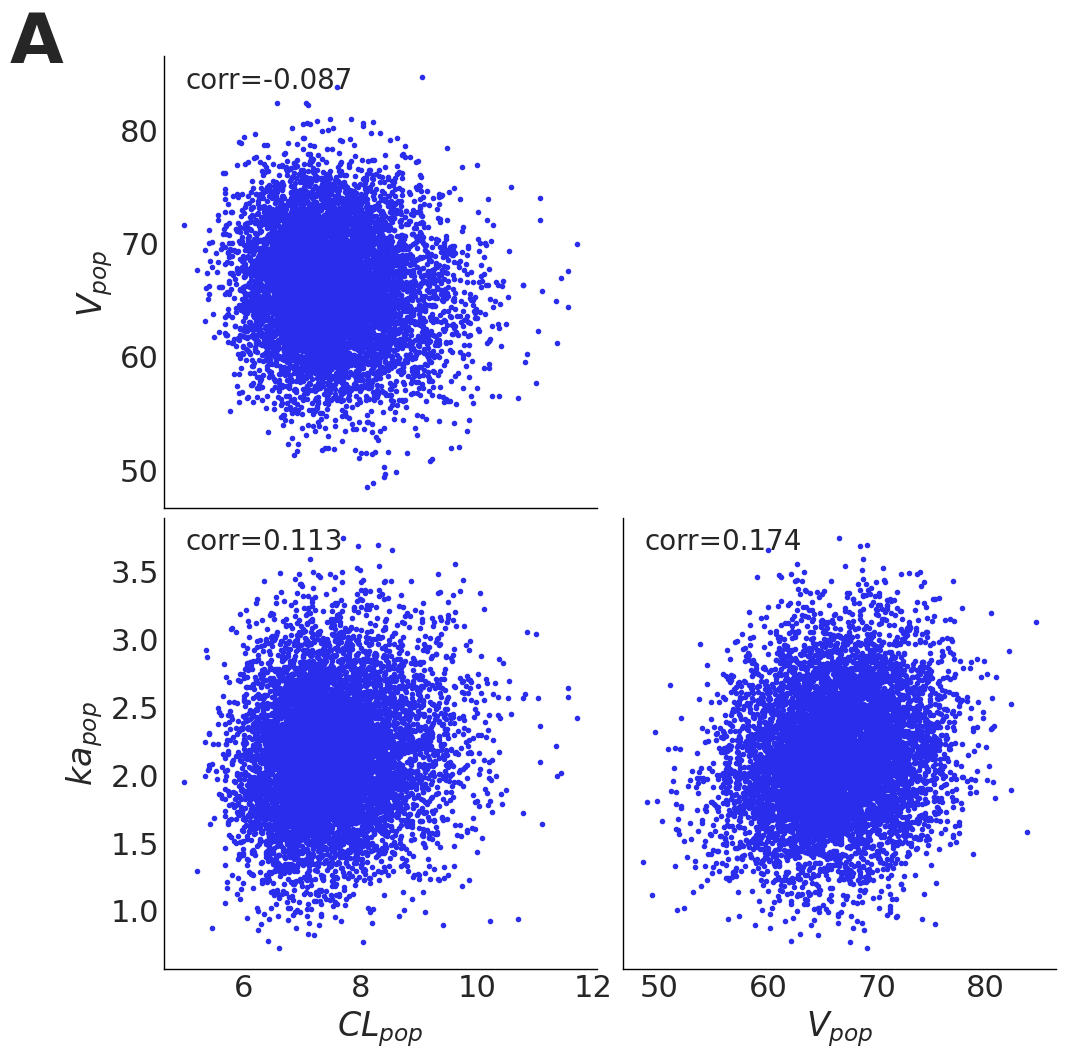

In [25]:
interest_vars=['CL_pop', 'V1_pop', 'ka_pop']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
with az.style.context("arviz-white", after_reset=True):
    az.plot_pair(chains, var_names=interest_vars, figsize=(10, 10), divergences=True, ax=ax) 
    ax[0, 0].set_ylabel(r'$V_{pop}$')
    ax[1, 0].set_ylabel(r'${ka}{_{pop}}$')
    ax[1, 0].set_xlabel(r'${CL}_{pop}$')
    ax[1, 1].set_xlabel(r'$V_{pop}$')
    ax[0, 0].annotate('corr='+str(np.round(rVCL[0], 3)), xy=(0.05, 0.93), xycoords='axes fraction', size=20)
    ax[1, 0].annotate('corr='+str(np.round(rCLka[0], 3)), xy=(0.05, 0.93), xycoords='axes fraction', size=20)
    ax[1, 1].annotate('corr='+str(np.round(rVka[0], 3)), xy=(0.05, 0.93), xycoords='axes fraction', size=20)
    
    font_size(ax, labelsize=24, ticksize=22)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.text(-0.05, 0.99, 'A', fontsize=50, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelA_pairs.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_pairs.eps', dpi=600, bbox_inches='tight')

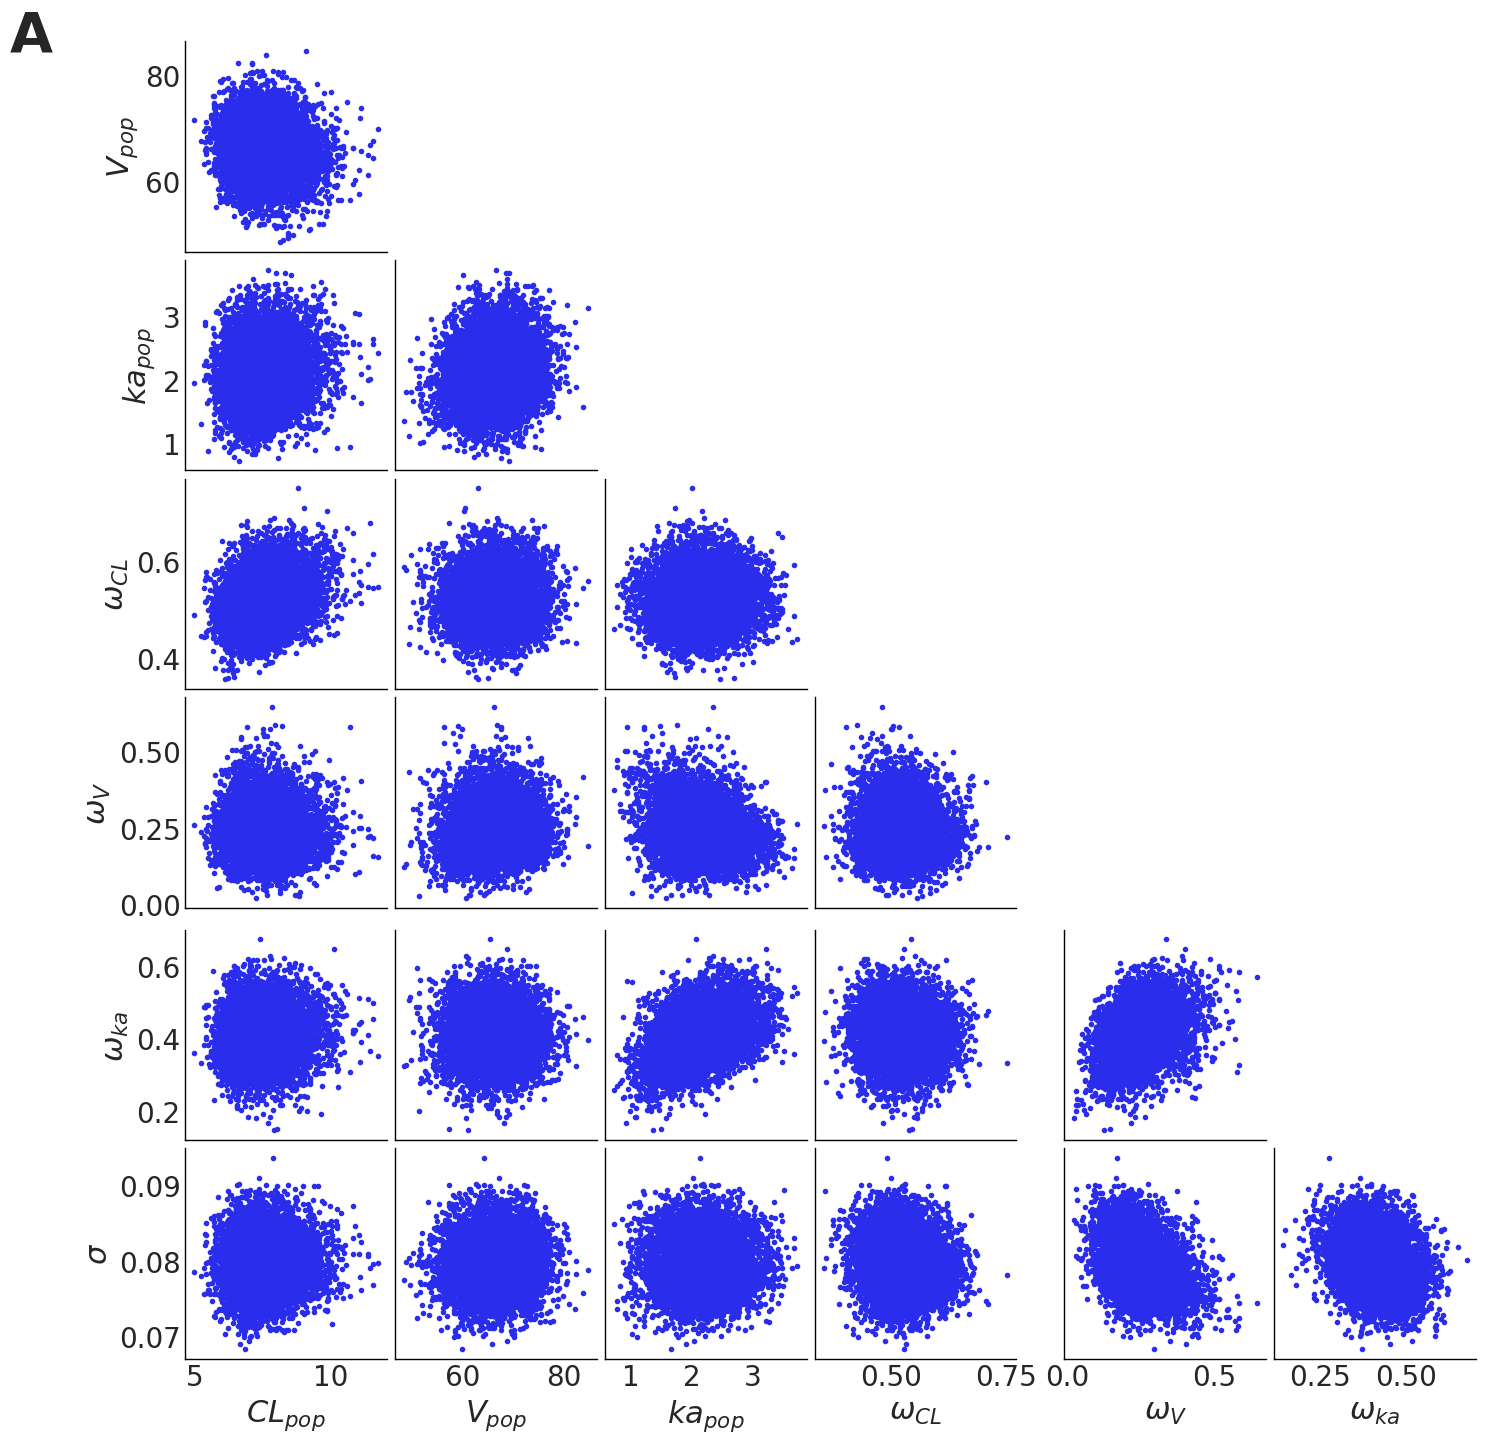

In [26]:
interest_vars=['CL_pop', 'V1_pop', 'ka_pop', 'omega', 'sigma']
var_names = [r'$CL_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$', r'$\omega_{CL}$', r'$\omega_V$', r'$\omega_{ka}$',
             r'$\sigma$']

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(14, 14))
with az.style.context("arviz-white", after_reset=True):
    az.plot_pair(chains, var_names=interest_vars, divergences=True, ax=ax) 
    for i in range(len(var_names)-1) :
        ax[-1, i].set_xlabel(var_names[i])
        ax[i , 0].set_ylabel(var_names[i+1])
    font_size(ax, labelsize=22, ticksize=20)
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.text(-0.05, 0.99, 'A', fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelA_pairs_all.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_pairs_all.eps', dpi=600, bbox_inches='tight')

In [51]:
import itertools
interest_vars=['CL_pop', 'V1_pop', 'ka_pop', 'sigma', 'omega']
r_list = []
for var_i, var_j in itertools.product(interest_vars, interest_vars):
    if var_i != var_j :
        if var_i == 'omega' and var_j != 'omega' :
            for i in range(3) :
                r_list.append(pearsonr(chains.posterior[var_i][:, :, i].to_numpy().flatten(), 
                                   chains.posterior[var_j].to_numpy().flatten())[0])
                print(var_i, i, var_j, r_list[-1])
        elif var_j == 'omega' and var_i != 'omega' :
            continue
        else :
            r_list.append(pearsonr(chains.posterior[var_i].to_numpy().flatten(), 
                                   chains.posterior[var_j].to_numpy().flatten())[0])
            print(var_i, var_j, r_list[-1])

CL_pop V1_pop -0.08671149454421717
CL_pop ka_pop 0.11325947027519118
CL_pop sigma 0.033685548470698136
V1_pop CL_pop -0.08671149454421717
V1_pop ka_pop 0.1744427619685879
V1_pop sigma 0.031217466898938007
ka_pop CL_pop 0.11325947027519118
ka_pop V1_pop 0.1744427619685879
ka_pop sigma -0.00965679560935976
sigma CL_pop 0.033685548470698136
sigma V1_pop 0.031217466898938007
sigma ka_pop -0.00965679560935976
omega 0 CL_pop 0.2665302863508383
omega 1 CL_pop 0.010215077789832258
omega 2 CL_pop 0.05314998744773042
omega 0 V1_pop 0.010802452716112902
omega 1 V1_pop 0.09919862921519154
omega 2 V1_pop -0.021683038021585298
omega 0 ka_pop 0.0166807806352247
omega 1 ka_pop -0.21937439355792224
omega 2 ka_pop 0.39876485479102636
omega 0 sigma -0.09493107581379436
omega 1 sigma -0.29902290355394867
omega 2 sigma -0.21396033933667558


/tmp/ipykernel_20641/2468771835.py:24: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=2)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


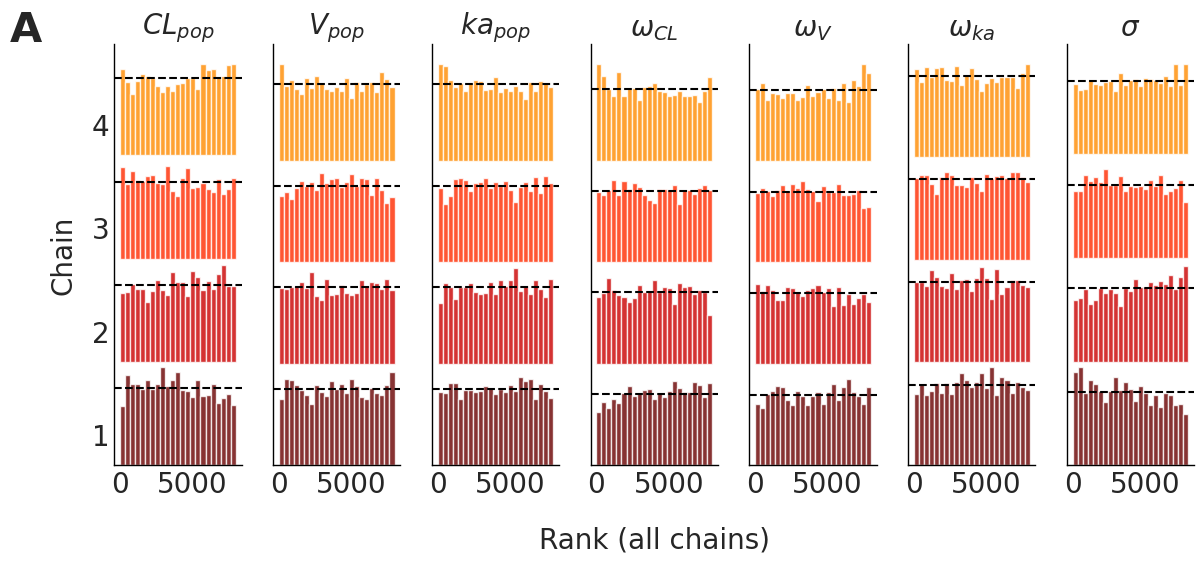

In [27]:
popvar_names = ['CL_pop', 'V1_pop', 'ka_pop', 'omega', 'sigma']
var_labels = [r'${CL}_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$', 
              r'$\omega_{CL}$', r'$\omega_{V}$', r'$\omega_{ka}$', r'$\sigma$']
ncols = len(var_labels)
fig, ax = plt.subplots(ncols=ncols, figsize=(12, 6), sharex=True)
az.plot_rank(chains, var_names=popvar_names, colors=sns.color_palette("hot"), 
             bar_kwargs={'alpha':0.8}, ax=ax)
for a in ax.flatten() :
    a.set(title=var_labels[a.get_subplotspec().num1 % ncols])

    if not a.get_subplotspec().num1 % ncols == ncols//2 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    if not a.get_subplotspec().num1 % ncols == 0 :
        a.set(ylabel=None)
        a.yaxis.set_ticklabels([])
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=10)
        a.set_yticks(a.get_yticks() + [0.00005])
        a.set_yticklabels(np.arange(1, 5, 1).astype('str'))

font_size(ax)
plt.tight_layout(pad=2)
plt.text(-0.01, 0.9, 'A', fontsize=30, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelA_rank.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_rank.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/3717307328.py:39: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=1)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


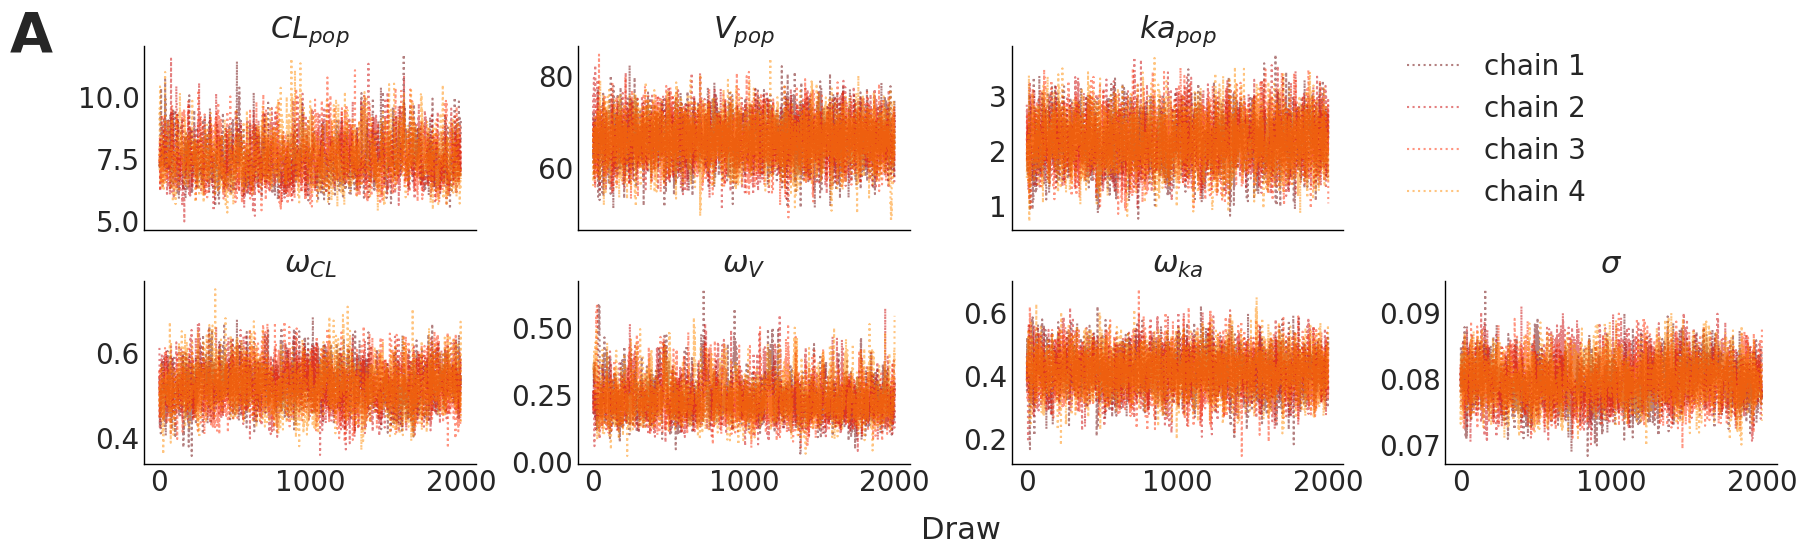

In [28]:
var_labels = [r'${CL}_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$', 
              r'$\omega_{CL}$', r'$\omega_{V}$', r'$\omega_{ka}$', r'$\sigma$']

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 6), sharex=True)
chain_colors = sns.color_palette("hot")
for ichain in range(4) :
    ax[0, 0].plot(chains.posterior['CL_pop'][ichain, :], color=chain_colors[ichain], 
                  linestyle=':', alpha=.5, 
                  label='chain '+ str(ichain+1))
    ax[0, 1].plot(chains.posterior['V1_pop'][ichain, :], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[0, 2].plot(chains.posterior['ka_pop'][ichain, :], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 3].plot(chains.posterior['sigma'][ichain, :], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 0].plot(chains.posterior['omega'][ichain, :, 0], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 1].plot(chains.posterior['omega'][ichain, :, 1], color=chain_colors[ichain], linestyle=':', alpha=.5)
    ax[1, 2].plot(chains.posterior['omega'][ichain, :, 2], color=chain_colors[ichain], linestyle=':', alpha=.5)
    
h, l = ax[0, 0].get_legend_handles_labels()

ia = 0
for a in ax.flatten() :
    
    if a.get_subplotspec().num1 != 3:
        a.set_title(var_labels[ia])
        ia += 1

    else :
        a.spines['left'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.xaxis.set_visible(False)
        a.yaxis.set_visible(False)
        a.legend(h, l, fontsize=20,  bbox_to_anchor=(0.5, 1.1))
        
font_size(ax, labelsize=22, ticksize=20)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Draw', labelpad=20, size=22)

plt.tight_layout(pad=1)
plt.text(-0.01, 0.9, 'A', fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelA_chains.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_chains.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/1105558620.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=2)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


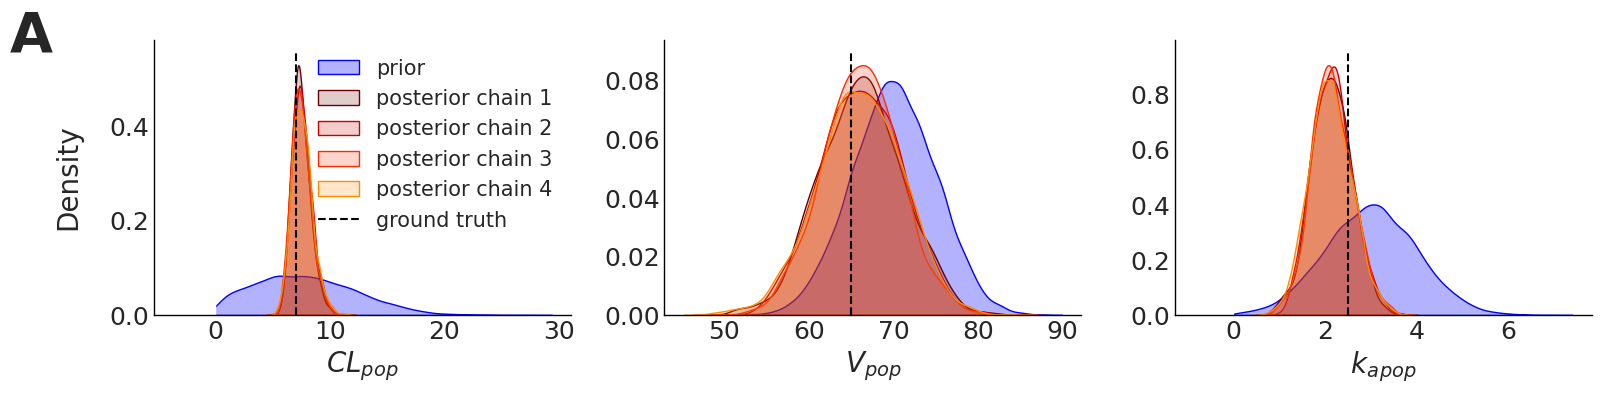

In [29]:
CL_prior = np.random.normal(float(chains.observed_data['CL_pop_meanPrior']), 5, size=10000)
V_prior = np.random.normal(float(chains.observed_data['V1_pop_meanPrior']), 5, size=10000)
ka_prior = np.random.normal(float(chains.observed_data['ka_pop_meanPrior']), 1, size=10000)
PK_priors = [CL_prior[CL_prior >=0], V_prior[V_prior >=0], ka_prior[ka_prior >= 0]]
PK_posts = [chains.posterior['THETA_pop'][:, :, i].to_numpy() for i in range(3)]
fig3, ax = plot_prior_posterior(PK_priors, PK_posts, names=[r'$CL_{pop}$', r'$V_{pop}$', r'${k_a}_{pop}$'])
add_true_values(ax, legend_loc='upper right')

for a in ax.flatten() :
    if a.get_xlim()[0] < 0 :
        xblank = [a.get_xlim()[0], -0.001]
        a.fill_between(xblank, 0, 0.1, color='white', step='post')
        
font_size(ax, labelsize=20, ticksize=18)
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h, l, fontsize=15)

fig.add_subplot(111, frameon=False)
#plt.text(0.95, 0.85, 'A', fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.tight_layout(pad=2)
plt.text(-0.01, 0.9, 'A', fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelA_priorpost.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_priorpost.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/1936660586.py:53: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=.8)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


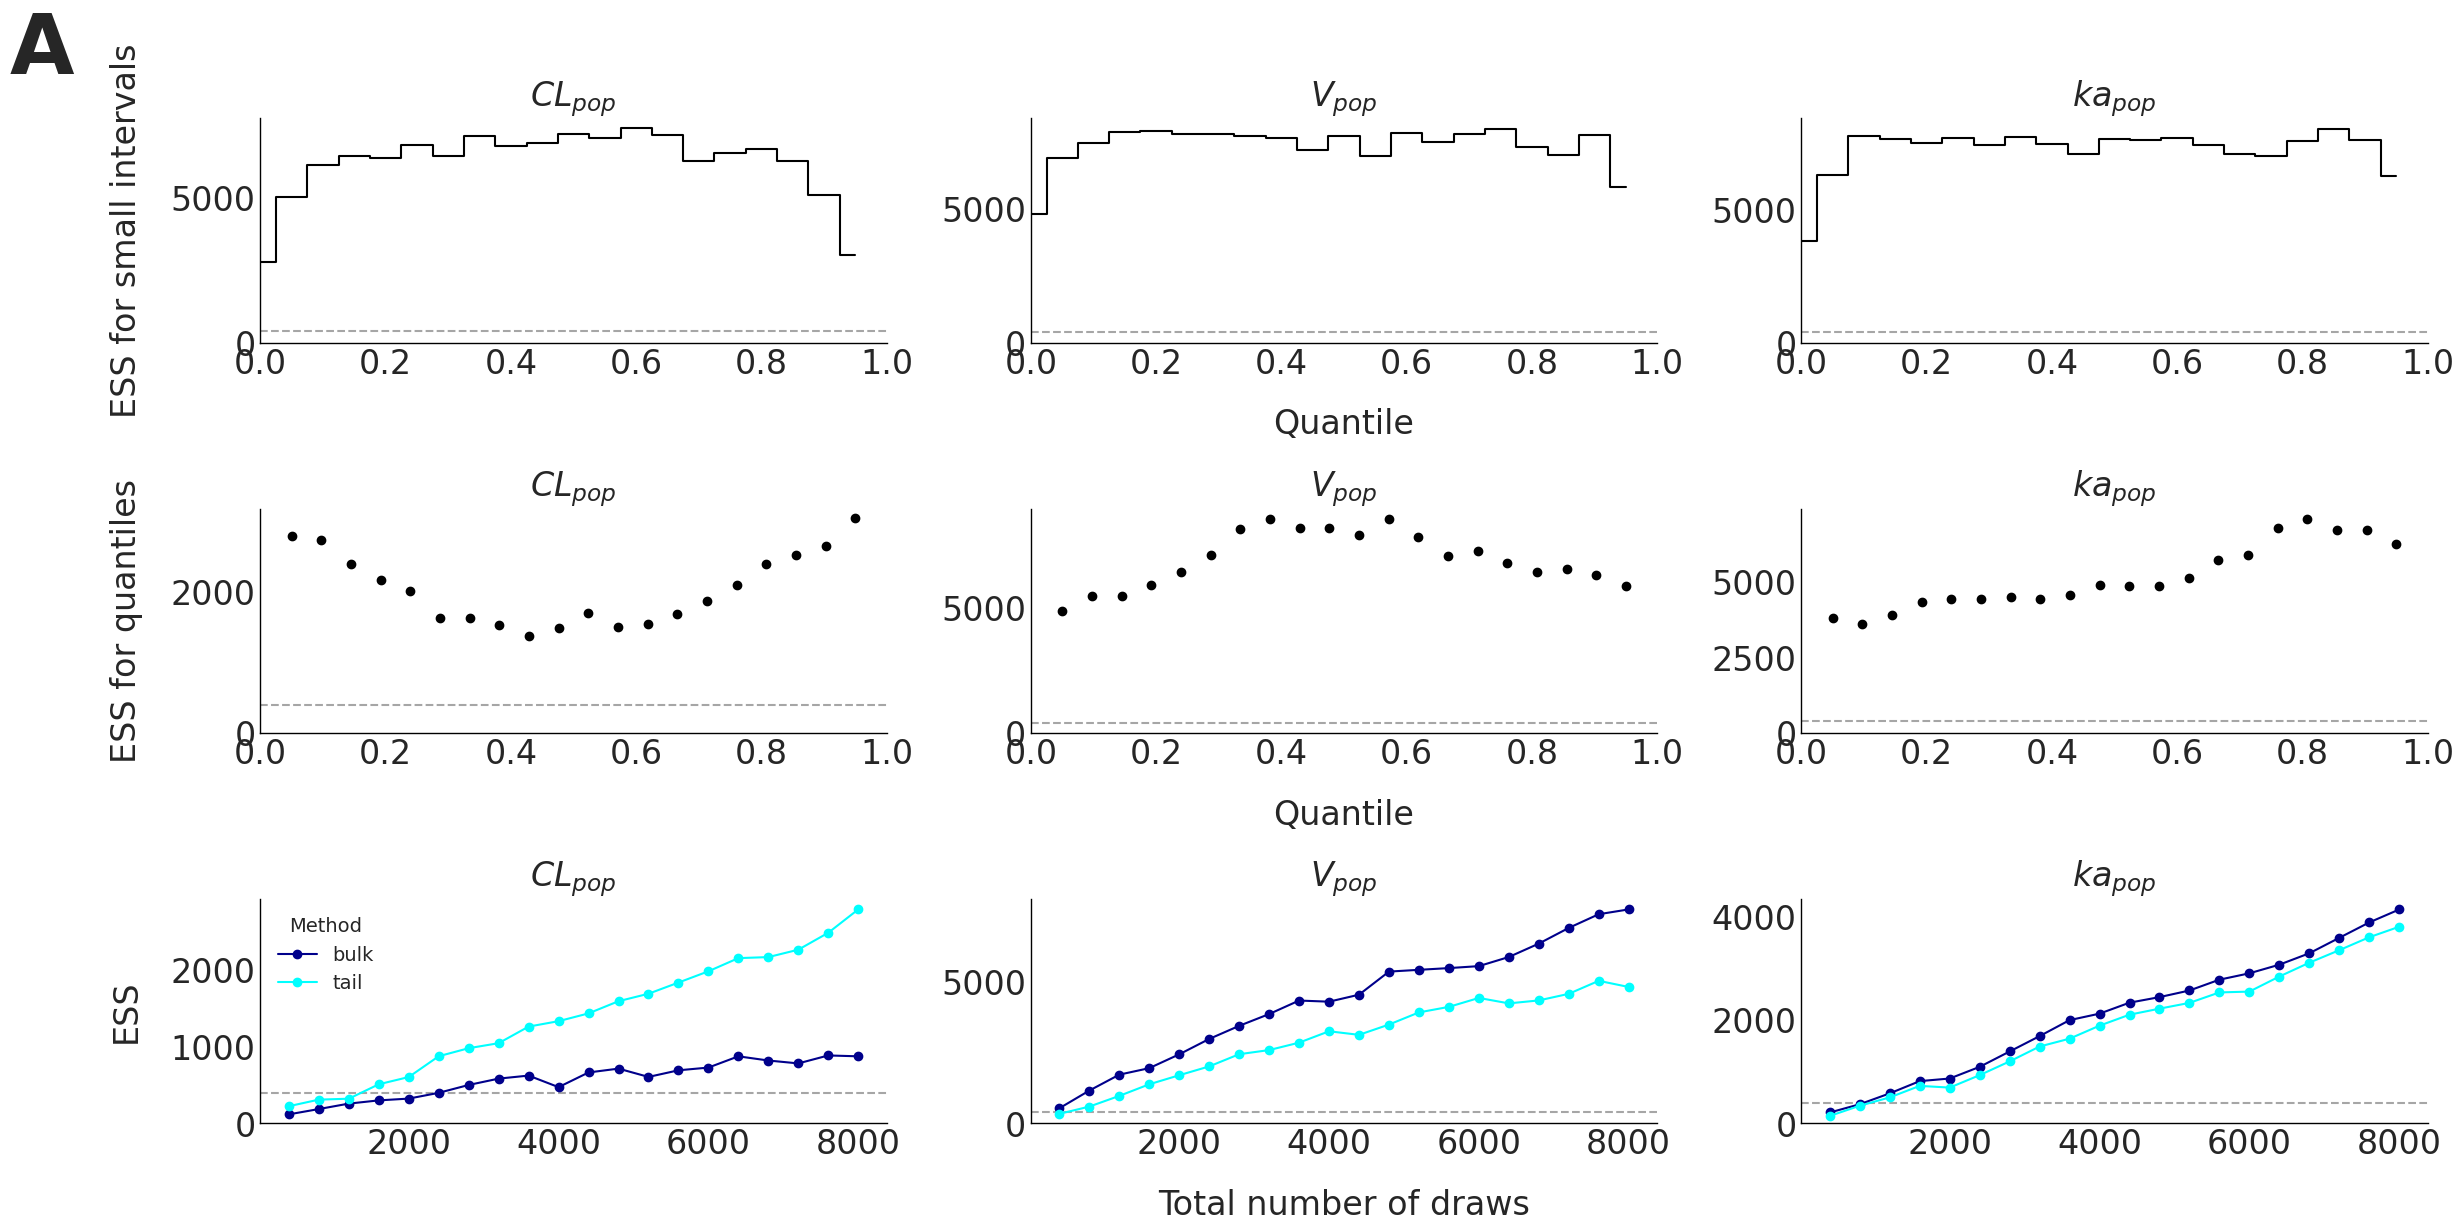

In [30]:
pop_var_names = ['CL_pop', 'V1_pop', 'ka_pop']
var_labels = [r'${CL}_{pop}$', r'$V_{pop}$', r'${ka}_{pop}$']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8*3, 4*3))


az.plot_ess(chains, var_names=pop_var_names, ax = ax[0, :], kind='local',
            drawstyle="steps-mid", linestyle='-', marker=None, color='black') 

for a in ax[0, :].flatten():
    if not a.get_subplotspec().is_first_col() :
        a.set(ylabel=None)
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=20)
    if not a.get_subplotspec().num1 % 3 == 1 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    a.set(title=var_labels[a.get_subplotspec().num1 % 3])

    
az.plot_ess(chains, var_names=pop_var_names, ax = ax[1, :], kind='quantile',
           color='black') 

for a in ax[1, :].flatten():
    if not a.get_subplotspec().is_first_col() :
        a.set(ylabel=None)
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=20)
    if not a.get_subplotspec().num1 % 3 == 1 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    a.set(title=var_labels[a.get_subplotspec().num1 % 3])
    
    
az.plot_ess(chains, var_names=pop_var_names, kind='evolution', ax=ax[2, :], 
            color='darkblue', extra_kwargs={'color':'cyan'})

for a in ax[2, :].flatten():
    if not a.get_subplotspec().is_first_col() :
        a.get_legend().remove() 
        a.set(ylabel=None)
    else :
        a.set_ylabel(a.get_ylabel(), labelpad=20)
    if not a.get_subplotspec().num1 % 3 == 1 :
        a.set(xlabel=None)
    else :
        a.set_xlabel(a.get_xlabel(), labelpad=20)
    a.set(title=var_labels[a.get_subplotspec().num1 % 3])
    
font_size(ax, labelsize=24, ticksize=24)
fig.subplots_adjust(hspace=.8)
plt.tight_layout(pad=2)
plt.text(-0.03, 0.98, 'A',fontsize=60, transform=plt.gcf().transFigure, weight='bold')

plt.savefig('plots/modelA_ess.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_ess.eps', dpi=600, bbox_inches='tight')

In [56]:
ess_inter2 = az.ess(chains)
stepsize_inter2 = chains.sample_stats['step_size']
nstep_inter2 = chains.sample_stats['n_steps']

In [57]:
nstep_inter2.mean()

<xarray.DataArray 'n_steps' ()>
array(120.904)

In [58]:
nstep_inter2.std()

<xarray.DataArray 'n_steps' ()>
array(18.78783606)

In [59]:
stepsize_inter2.mean()

<xarray.DataArray 'step_size' ()>
array(0.04568115)

In [60]:
stepsize_inter2.std()

<xarray.DataArray 'step_size' ()>
array(0.00010219)

In [61]:
essA_dict = ess_inter2.to_dict()
essA = pd.DataFrame(essA_dict)
essA_new = essA['CL_pop':'cHatPred'].drop(['THETA_pop', 'THETA_norm', 'THETAPred_norm']) #duplicates
essA_new = essA_new['data_vars'].apply(lambda x: list(x.values())[-1])

In [62]:
essA_new

CL_pop                                                  873.397581
V1_pop                                                  7582.41004
ka_pop                                                 4147.732336
L                [[8000.0, 8000.0, 8000.0], [1232.6517871389522...
omega            [446.4187587735789, 1403.6739360695556, 4682.3...
etaStd           [[6505.402149679819, 11416.755239817121, 8274....
sigma                                                   496.370245
THETA_ind        [[6935.182068946195, 10198.159899301869, 6739....
X                [[8019.060899610506, 7408.7474333448245], [801...
cHat             [7033.790160727765, 7033.764167281698, 7033.80...
cHatObs          [6902.78042175383, 6913.610573070773, 6942.541...
logcHatObs       [6902.732324107729, 6913.615605279088, 6942.55...
etaStdPred       [[7781.29772929257, 8165.66784088795, 7710.770...
THETAPred_ind    [[7319.96583873707, 8246.740955509462, 7458.25...
XPred            [[6990.592091354359, 6994.482435167412], [694

In [63]:
essA_new.apply(lambda x: np.mean(x)).mean()

5867.3399143474635

In [64]:
essA_new.apply(lambda x: np.min(x)).min()

64.64260514020967

In [65]:
essA_new.apply(lambda x: np.max(x)).max()

13366.62662434168

In [66]:
az.waic(chains, scale='deviance')

/home/xyz/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 by 427 log-likelihood matrix

              Estimate       SE
deviance_waic 82401.03  14030.63
p_waic        40669.36        -

There has been a warning during the calculation. Please check the results.

In [19]:
residuals_A = compute_res(chains)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


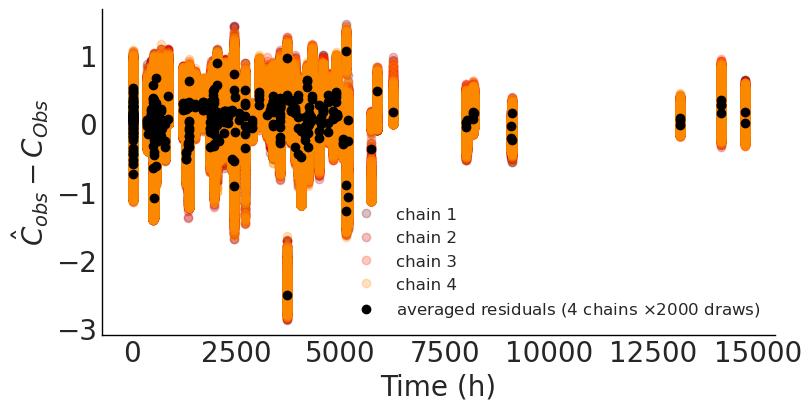

In [32]:
fig, ax = plot_residuals_time(chains, residuals_A) 
font_size(ax)
plt.savefig('plots/modelA_restime.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_restime.eps', dpi=600, bbox_inches='tight')

In [69]:
rmse_A = rmse(residuals_A)
rmse_A

0.34924363308154

/tmp/ipykernel_5389/2312003748.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=2)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


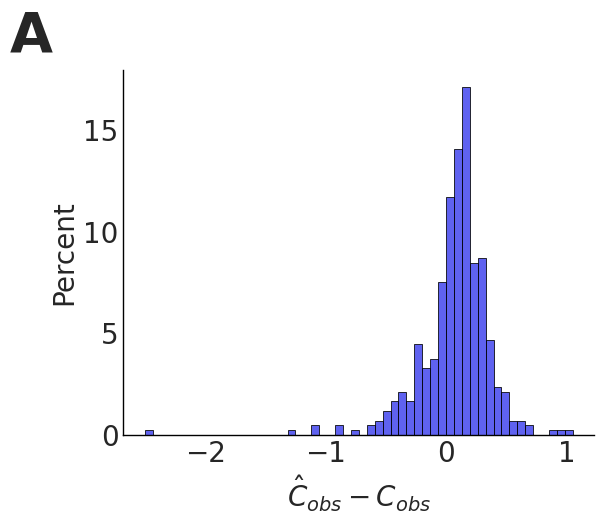

In [20]:
fig, ax = plot_res_hist(residuals_A, figsize=(6, 5))
font_size(ax)
plt.tight_layout(pad=2)
plt.text(-0.02, 0.98, 'A',fontsize=40, transform=plt.gcf().transFigure, weight='bold')
plt.savefig('plots/modelA_res.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_res.eps', dpi=600, bbox_inches='tight')

/tmp/ipykernel_20641/3471832706.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=1)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


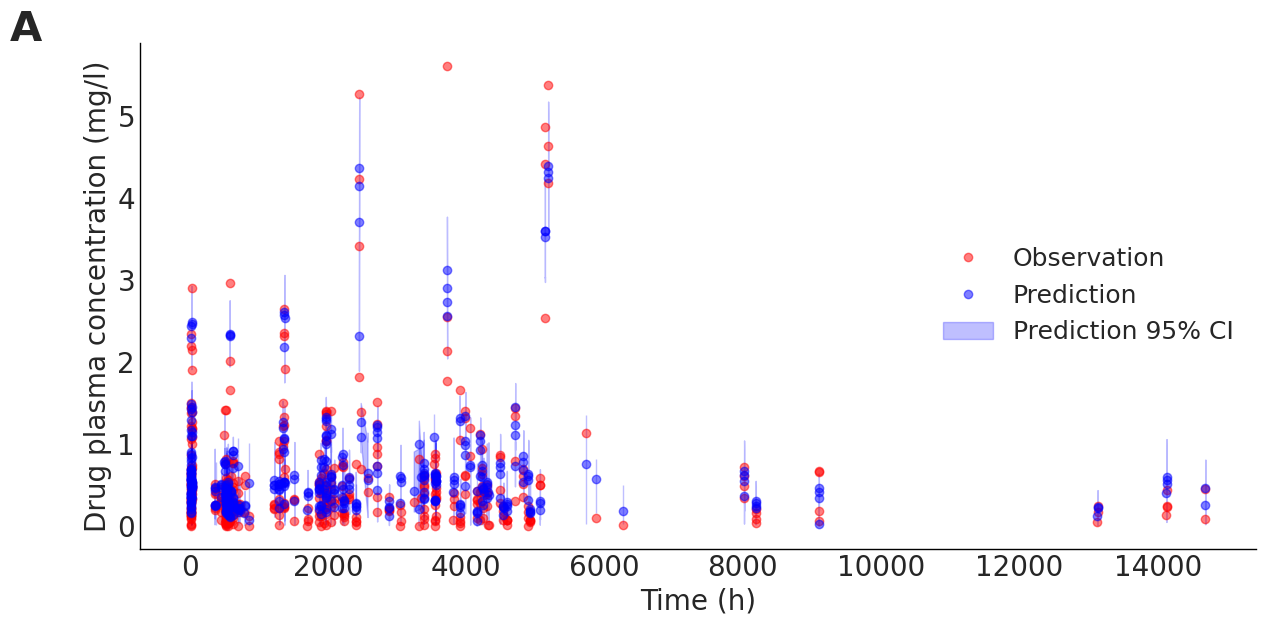

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
TIME = chains.observed_data['TIME']
tObs = chains.observed_data['tObs']

cPred = chains.posterior_predictive['cPred_ind'].to_numpy()
iObs = chains.observed_data['iObs'].to_numpy() - 1
cPredObs = cPred[:, :, iObs]

cPredmean = np.mean(cPredObs, axis=0).mean(axis=0)
qlower = np.quantile(cPredObs, 0.025, axis=[0,1])
qupper = np.quantile(cPredObs, 0.975, axis=[0,1])

t_reset = np.add(np.where(np.abs(np.diff(tObs)) > (24*7))[0].astype('int'), 1)
t_reset = np.insert(t_reset, 0, 0)
t_reset = np.append(t_reset, len(t_reset)-1)

ax.plot(tObs, chains.observed_data['cObs'], 'or', alpha=0.5, label='Observation')

for t in range(len(t_reset)-1) :
    ax.plot(tObs[t_reset[t]:t_reset[t+1]], cPredmean[t_reset[t]:t_reset[t+1]],
            'ob', alpha=0.5, label='Prediction') 
    ax.fill_between(tObs[t_reset[t]:t_reset[t+1]],
                    qlower[t_reset[t]:t_reset[t+1]],
                    qupper[t_reset[t]:t_reset[t+1]],
                    alpha=0.25, color='blue', label='Prediction 95% CI')
    if t==0 :
        ax.legend()
h, l = ax.get_legend_handles_labels()
ax.legend(h[:3], l[:3], fontsize=18, loc='center right')
ax.set(xlabel='Time (h)', ylabel='Drug plasma concentration (mg/l)')
font_size(ax)
plt.tight_layout(pad=1)
plt.text(-0.05, 0.98, 'A', fontsize=30, transform=plt.gcf().transFigure, weight='bold')

plt.savefig('plots/modelA_cPred.png', dpi=600, bbox_inches='tight')
plt.savefig('plots/modelA_cPred.eps', dpi=600, bbox_inches='tight')

In [73]:
rhat = az.rhat(chains)

/home/xyz/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [75]:
rhat_01 = rhat > 1.01 

In [76]:
rhat_dict = rhat_01.sum().to_dict()
rhat_df = pd.DataFrame(rhat_dict)
rhat_new = rhat_df['CL_pop':'cHatPred'].drop(['THETA_pop', 'THETA_norm', 'THETAPred_norm']) #duplicates
rhat_new = rhat_new['data_vars'].apply(lambda x: list(x.values())[-1])

In [77]:
rhat_new[:'THETA_ind'].sum() / 418 #percent of parameters with rhat > 1.01

0.0215311004784689